# **Bibliotecas**

In [ ]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Mama e Próstata Juntos**

**Sem TOPOGRUP**

## **Dados**

In [ ]:
!gdown 17zM_C6hBXD04almLkOw_lrCVyc339T73 --quiet # Mama treino
!gdown 17yy_juIUm02TooYE6PAX2MSzM1VjvYq1 --quiet # Mama teste
!gdown 17zGad6DS9tXVTGyw56j59mIMesz8Dq83 --quiet # Próstata treino
!gdown 181kx3XNGgjKNPW7GtDC1zqtL9Hz3JDVA --quiet # Próstata teste

In [ ]:
df_mama_treino = pd.read_csv('/content/mama_treino_3anos.csv')
print(df_mama_treino.shape)
df_mama_treino.head(3)

(75693, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,1.352201,0.078023,0.855700,-0.774058,-0.898638,-1.166659,-0.137075,0.545284,1.009224,-1.542157,...,0.912401,-0.854011,-0.670762,0.745516,-0.804498,-0.017031,0.958238,-0.517314,0,1
1,0.767303,0.078023,-1.456854,-0.774058,1.112795,-1.166659,-0.137075,0.545284,-0.990860,-1.542157,...,1.288153,2.102508,1.848145,0.745516,-0.804498,-0.977651,-1.043582,-0.517314,0,1
2,-0.768055,0.078023,0.855700,1.228497,1.112795,1.722849,-0.137075,-1.833906,-0.990860,0.648443,...,-0.026978,-0.854011,-0.670762,0.745516,0.579917,0.943589,0.958238,1.933063,0,0


In [ ]:
df_prost_treino = pd.read_csv('/content/prost_treino_3anos.csv')
print(df_prost_treino.shape)
df_prost_treino.head(3)

(60432, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.082486,0.0,-0.325918,-0.716132,0.735262,0.280252,-0.26085,1.123998,-0.720286,-0.306868,...,1.506622,-0.153154,-0.153287,-1.665773,-0.970784,0.315539,-0.897949,-0.413965,1,1
1,0.260425,0.0,-0.170011,-0.716132,0.735262,1.643727,-0.26085,-0.889682,-0.720286,-0.306868,...,-0.103215,1.263510,1.280904,-0.263251,-0.970784,-0.737744,1.113649,-0.413965,1,0
2,1.289155,0.0,-1.602573,-0.716132,-1.360059,0.734744,-0.26085,-0.889682,1.388338,-0.306868,...,1.305392,1.086427,0.802840,0.457569,0.440179,0.315539,-0.897949,-0.413965,1,1


In [ ]:
from sklearn.utils import shuffle

df_mama_prost_treino = pd.concat([df_mama_treino, df_prost_treino], ignore_index=True)
df_mama_prost_treino = shuffle(df_mama_prost_treino, random_state=seed)
df_mama_prost_treino.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
82562,0.146121,0.0,1.083307,1.341668,-1.360059,1.643727,-0.26085,-0.889682,1.388338,3.258727,...,-0.706905,0.023929,1.280904,0.457569,0.440179,-0.737744,-0.897949,-0.413965,1,1
128657,0.489031,0.0,-1.596970,-1.010104,-1.360059,-1.992207,-0.26085,1.123998,-0.720286,-0.306868,...,1.707852,-0.153154,-0.153287,0.849660,0.440179,2.422104,-0.897949,-0.413965,1,0
109667,0.031818,0.0,0.933235,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,-2.115512,1.440593,0.563808,0.821102,-0.970784,-0.737744,1.113649,-0.413965,1,1


In [ ]:
df_mama_teste = pd.read_csv('/content/mama_teste_3anos.csv')
print(df_mama_teste.shape)
df_mama_teste.head(3)

(25232, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.987392,0.078023,0.855700,-0.774058,1.112795,0.484489,-0.137075,-1.833906,-0.99086,0.648443,...,1.100277,-0.854011,-0.670762,0.745516,-0.804498,0.943589,0.958238,-0.517314,0,0
1,-0.841168,0.078023,1.111192,1.228497,-0.898638,0.897275,-0.137075,-1.833906,-0.99086,0.648443,...,-1.154233,0.069902,0.016212,-0.647069,0.579917,-0.017031,-1.043582,-0.517314,0,1
2,-0.329382,0.078023,-1.833992,-0.774058,1.112795,1.722849,-0.137075,-1.833906,-0.99086,-1.542157,...,0.724526,0.624249,0.245204,-1.832726,-0.804498,1.904208,0.958238,-0.517314,0,1


In [ ]:
df_prost_teste = pd.read_csv('/content/prost_teste_3anos.csv')
print(df_prost_teste.shape)
df_prost_teste.head(3)

(20144, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.603335,0.0,-0.539878,-0.716132,0.735262,1.643727,-0.26085,-0.889682,-0.720286,-0.306868,...,0.902933,1.086427,0.802840,0.457569,0.440179,0.315539,-0.897949,2.415663,1,1
1,-0.539699,0.0,-0.551315,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,0.500474,0.201012,0.802840,-1.694331,0.440179,1.368821,-0.897949,-0.413965,1,1
2,-0.196789,0.0,1.233322,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,0.500474,0.378095,0.085745,1.116050,-0.970784,0.315539,1.113649,-0.413965,1,1


In [ ]:
df_mama_prost_teste = pd.concat([df_mama_teste, df_prost_teste], ignore_index=True)
df_mama_prost_teste = shuffle(df_mama_prost_teste, random_state=seed)
df_mama_prost_teste.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
3893,-0.110045,0.078023,-0.625664,-0.774058,-0.898638,-1.579445,-0.137075,0.545284,1.009224,-1.542157,...,-0.402729,1.732943,0.703187,-1.749643,0.579917,1.904208,-1.043582,-0.517314,0,1
28530,0.603335,0.000000,0.962290,-0.716132,-1.360059,-0.628732,-0.260850,1.123998,-0.720286,3.258727,...,0.299244,-1.038570,-0.870382,0.849660,-0.970784,1.368821,1.113649,-0.413965,1,0
11228,2.229549,0.078023,0.855700,-1.060137,-0.898638,-1.579445,-0.137075,0.545284,1.009224,0.648443,...,0.348774,-0.854011,-0.670762,0.745516,0.579917,-0.977651,0.958238,-0.517314,0,1


In [ ]:
# Valores faltantes
df_mama_prost_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
TRATCONS              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
NENHUM                0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Valores faltantes
df_mama_prost_teste.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
TRATCONS              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
NENHUM                0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_mama_prost_treino.corr(numeric_only=True)
abs(corr_matrix['sobrevida_3anos']).sort_values(ascending = False).head(20)

sobrevida_3anos       1.000000
EC                    0.346180
CIRURGIA              0.225860
TRATCONS              0.147436
DIAGTRAT              0.145469
NENHUM                0.140777
IDADE                 0.131090
HORMONIO              0.123405
RADIO                 0.112039
ESCOLARI_preench      0.100464
CATEATEND             0.074137
presenca_rec          0.073588
DIAGPREV              0.066976
QUIMIO                0.058831
TOPOGRUP              0.048809
ANODIAG               0.013343
IBGE_idem_IBGEATEN    0.011967
HABILIT2              0.011486
CONSDIAG              0.010284
SEXO                  0.008204
Name: sobrevida_3anos, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_mama_prost_treino.sobrevida_3anos.value_counts()

1    110829
0     25296
Name: sobrevida_3anos, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TOPOGRUP', 'sobrevida_3anos']

# Treino
X_train = df_mama_prost_treino.drop(columns=list_drop).copy()
y_train = df_mama_prost_treino.sobrevida_3anos.copy()

# Teste
X_test = df_mama_prost_teste.drop(columns=list_drop).copy()
y_test = df_mama_prost_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((136125, 25), (136125,), (45376, 25), (45376,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

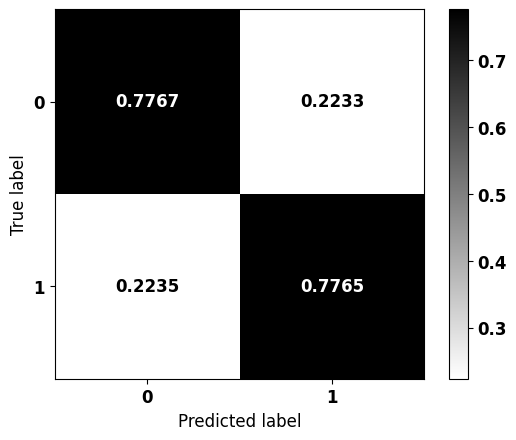


              precision    recall  f1-score   support

           0     0.4423    0.7767    0.5636      8432
           1     0.9384    0.7765    0.8498     36944

    accuracy                         0.7765     45376
   macro avg     0.6903    0.7766    0.7067     45376
weighted avg     0.8462    0.7765    0.7966     45376



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.1941,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

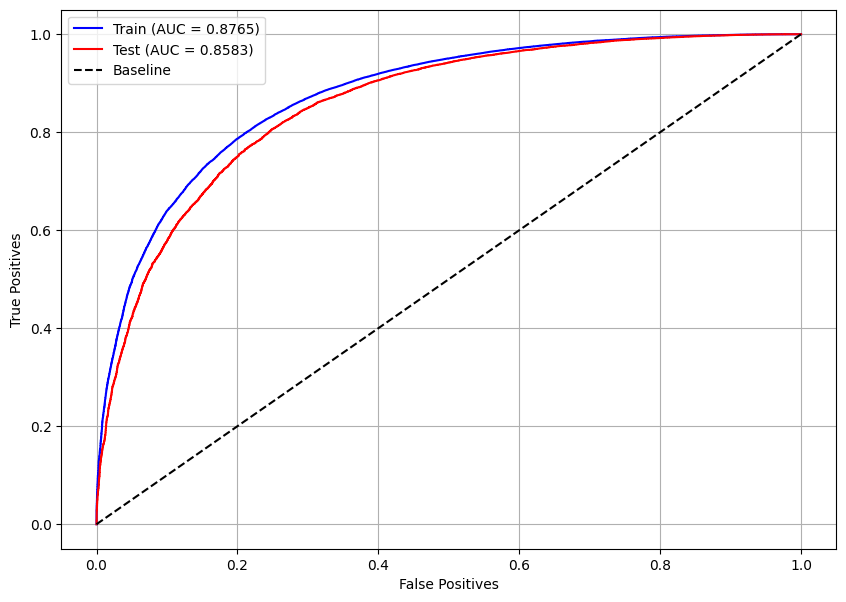

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

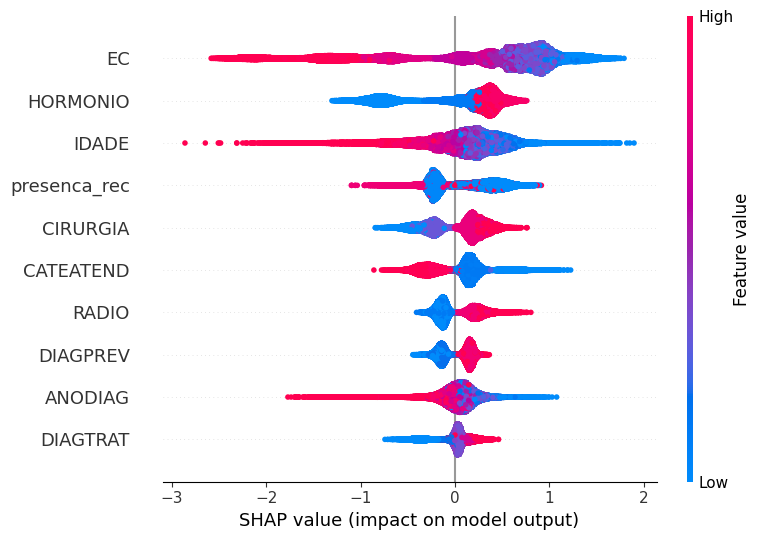

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 137,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.197, 0.199, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

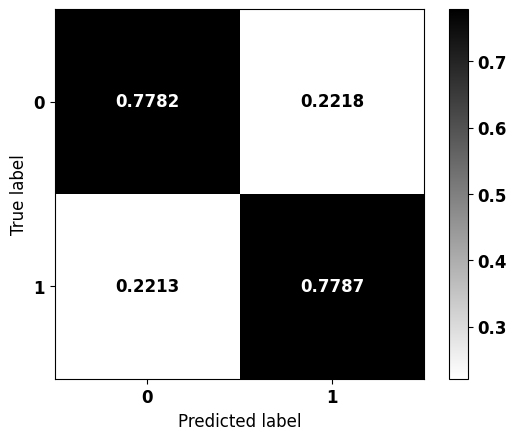


              precision    recall  f1-score   support

           0     0.4452    0.7782    0.5664      8432
           1     0.9390    0.7787    0.8514     36944

    accuracy                         0.7786     45376
   macro avg     0.6921    0.7785    0.7089     45376
weighted avg     0.8472    0.7786    0.7984     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1982

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

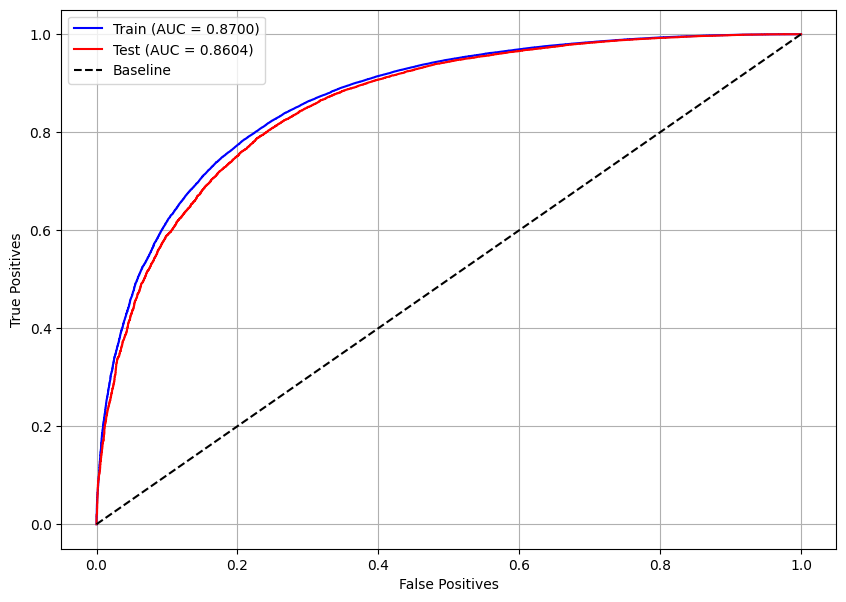

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 147,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.196, 0.199, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

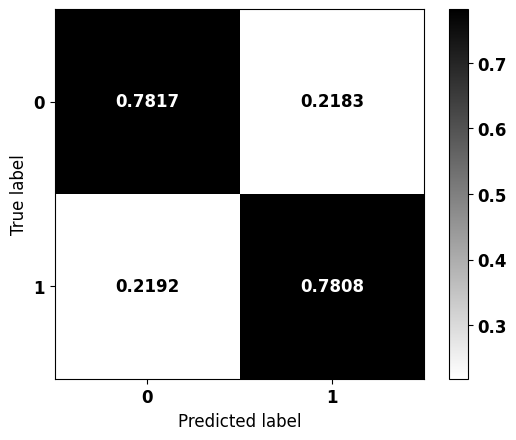


              precision    recall  f1-score   support

           0     0.4487    0.7817    0.5701      8432
           1     0.9400    0.7808    0.8530     36944

    accuracy                         0.7810     45376
   macro avg     0.6944    0.7812    0.7116     45376
weighted avg     0.8487    0.7810    0.8005     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1979

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

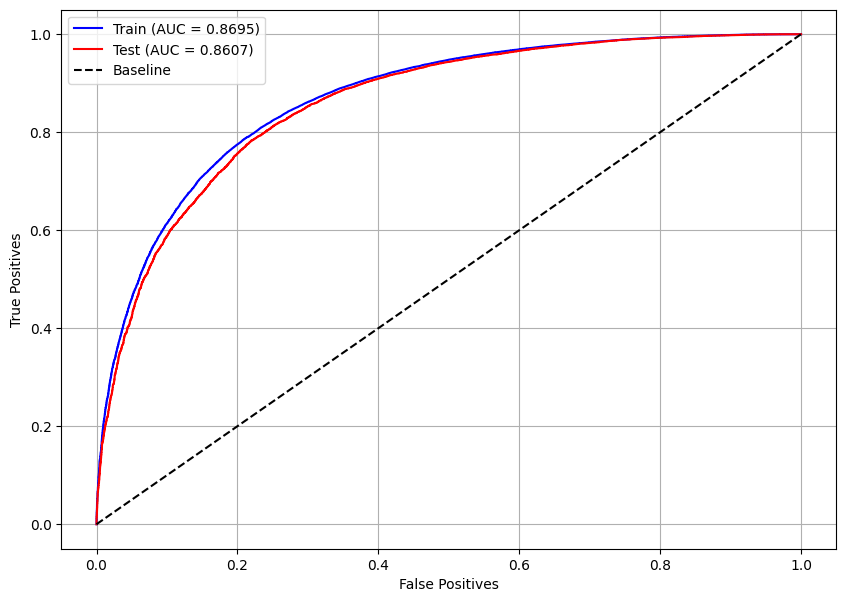

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
!pip install cmaes

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 118,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.197, 0.200, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

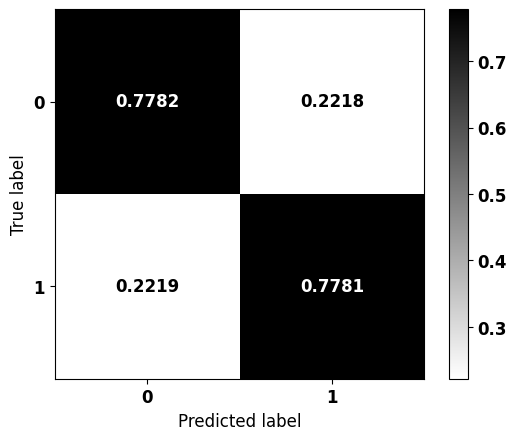


              precision    recall  f1-score   support

           0     0.4446    0.7782    0.5659      8432
           1     0.9389    0.7781    0.8510     36944

    accuracy                         0.7781     45376
   macro avg     0.6918    0.7782    0.7084     45376
weighted avg     0.8471    0.7781    0.7980     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1973

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

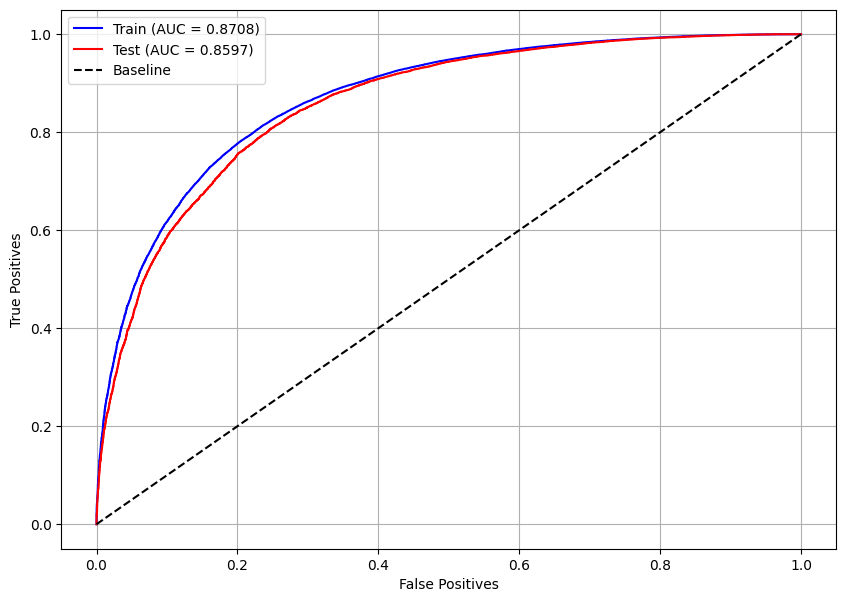

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

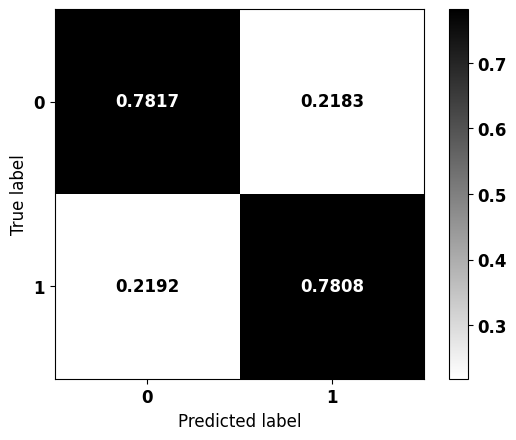


              precision    recall  f1-score   support

           0     0.4487    0.7817    0.5701      8432
           1     0.9400    0.7808    0.8530     36944

    accuracy                         0.7810     45376
   macro avg     0.6944    0.7812    0.7116     45376
weighted avg     0.8487    0.7810    0.8005     45376



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.2,
          'gamma': 0.2, 'min_child_weight': 7, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 0.1979

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

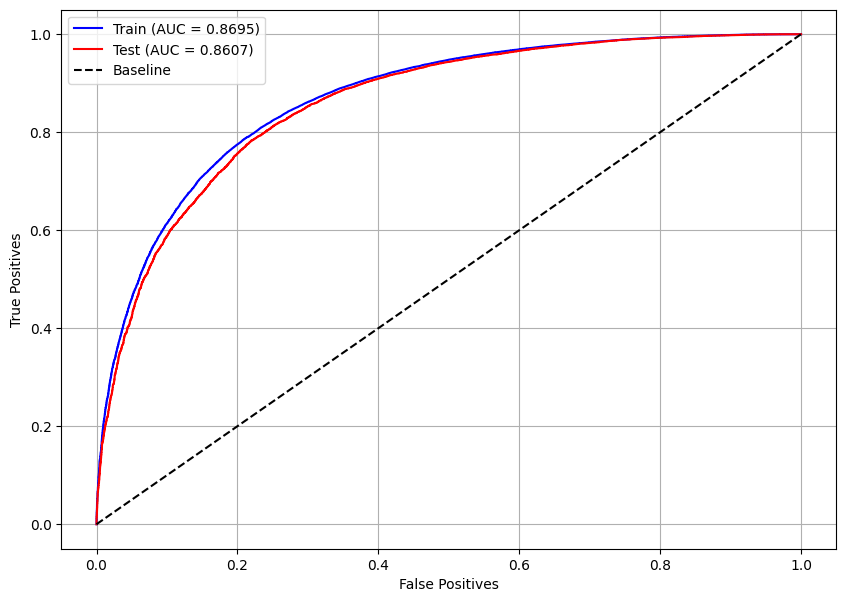

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

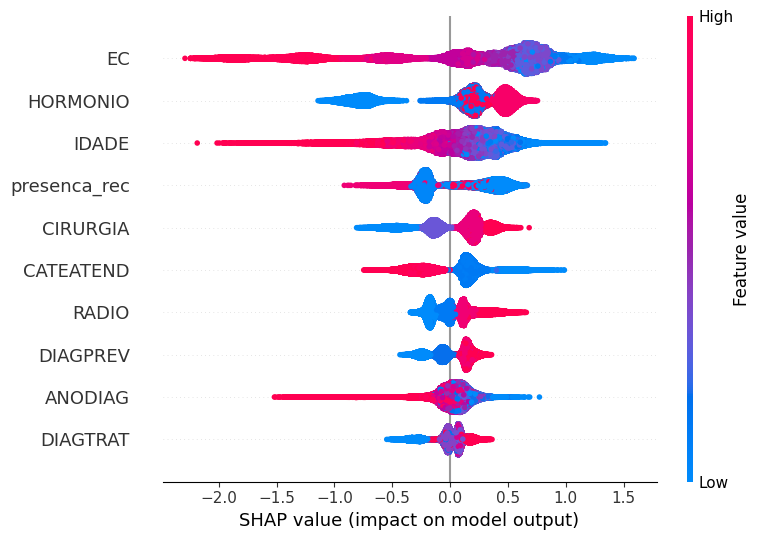

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

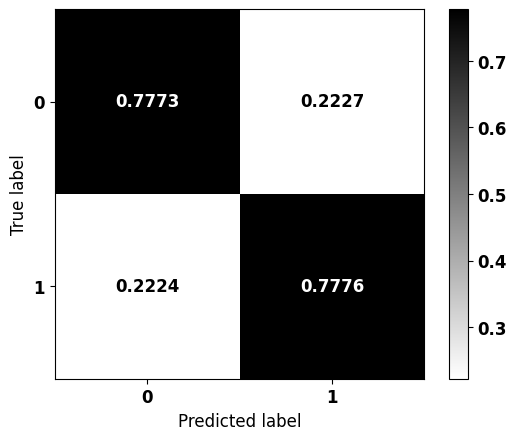


              precision    recall  f1-score   support

           0     0.4437    0.7773    0.5649      8432
           1     0.9386    0.7776    0.8505     36944

    accuracy                         0.7775     45376
   macro avg     0.6912    0.7774    0.7077     45376
weighted avg     0.8467    0.7775    0.7975     45376



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:4.94, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

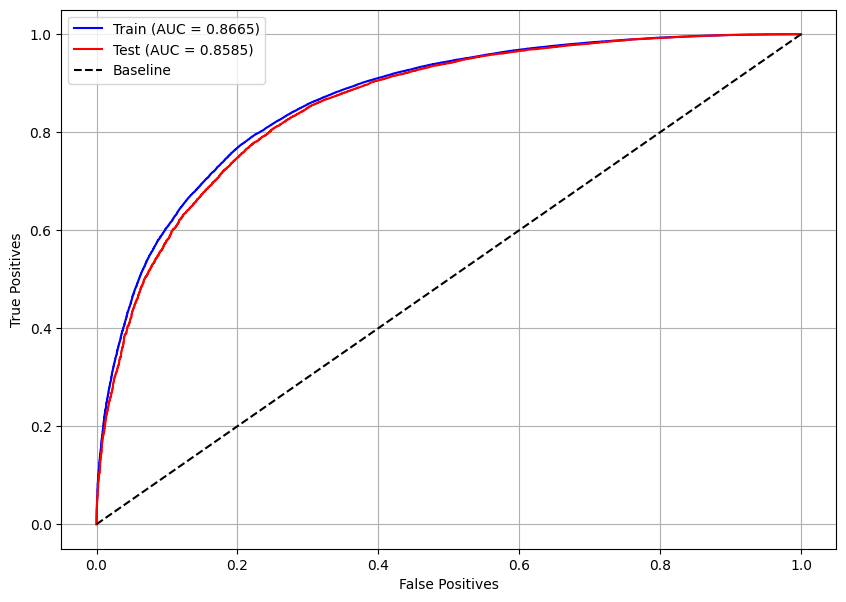

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

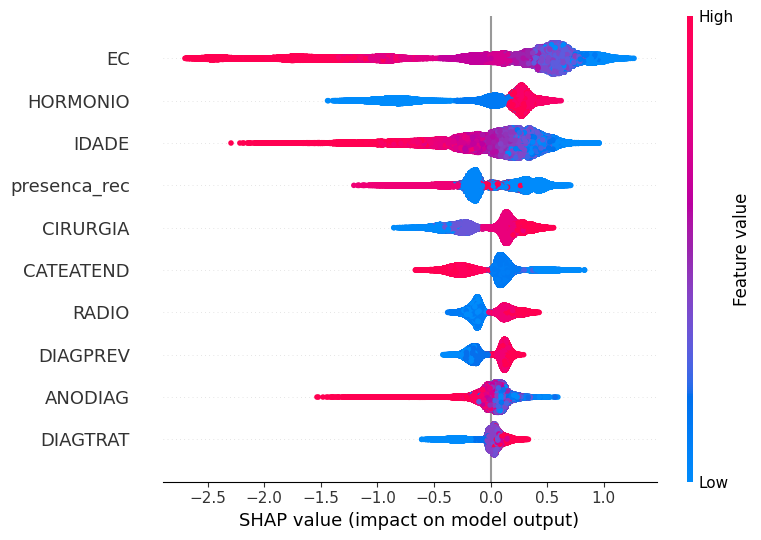

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 7,
 'learning_rate': 0.16,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(5, 5.15, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

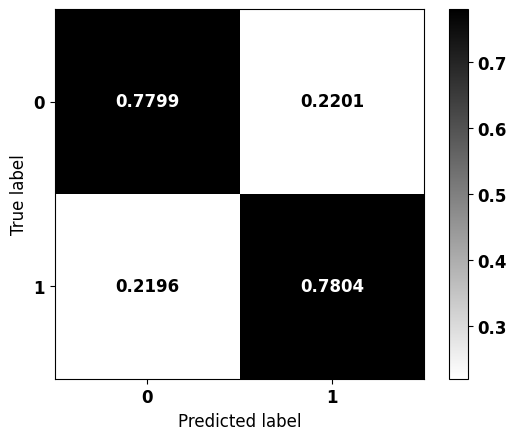


              precision    recall  f1-score   support

           0     0.4477    0.7799    0.5689      8432
           1     0.9395    0.7804    0.8526     36944

    accuracy                         0.7803     45376
   macro avg     0.6936    0.7802    0.7107     45376
weighted avg     0.8481    0.7803    0.7999     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.06, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

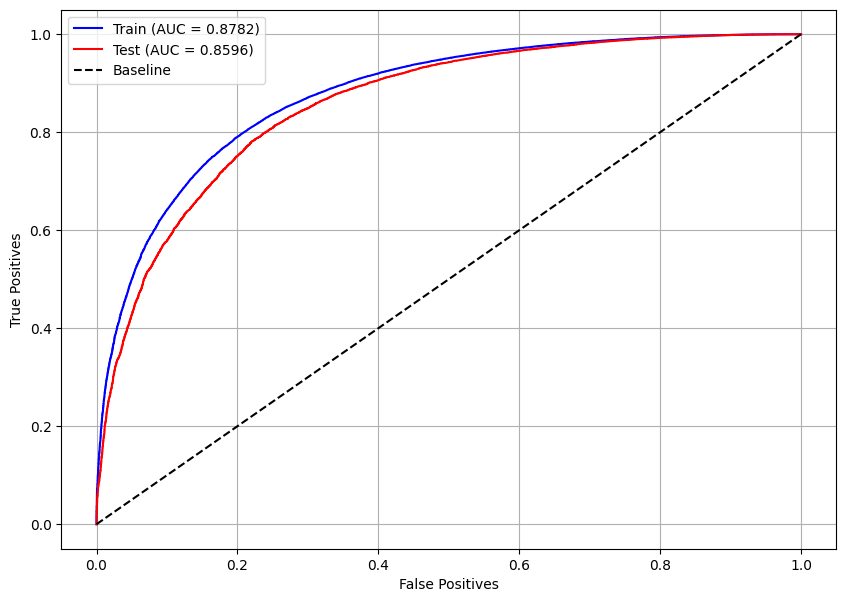

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 142,
 'max_depth': 10,
 'learning_rate': 0.19,
 'min_child_weight': 6,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(5.05, 5.2, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

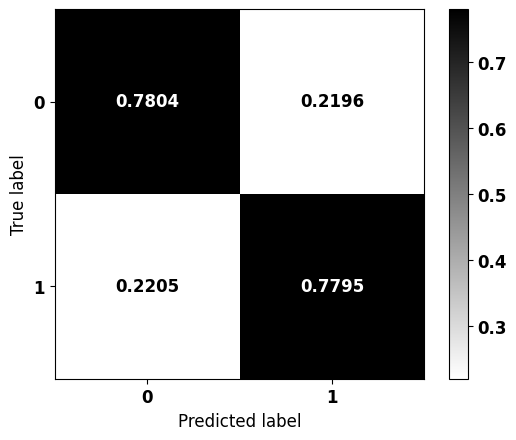


              precision    recall  f1-score   support

           0     0.4469    0.7804    0.5683      8432
           1     0.9396    0.7795    0.8521     36944

    accuracy                         0.7797     45376
   macro avg     0.6932    0.7799    0.7102     45376
weighted avg     0.8480    0.7797    0.7994     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.127, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

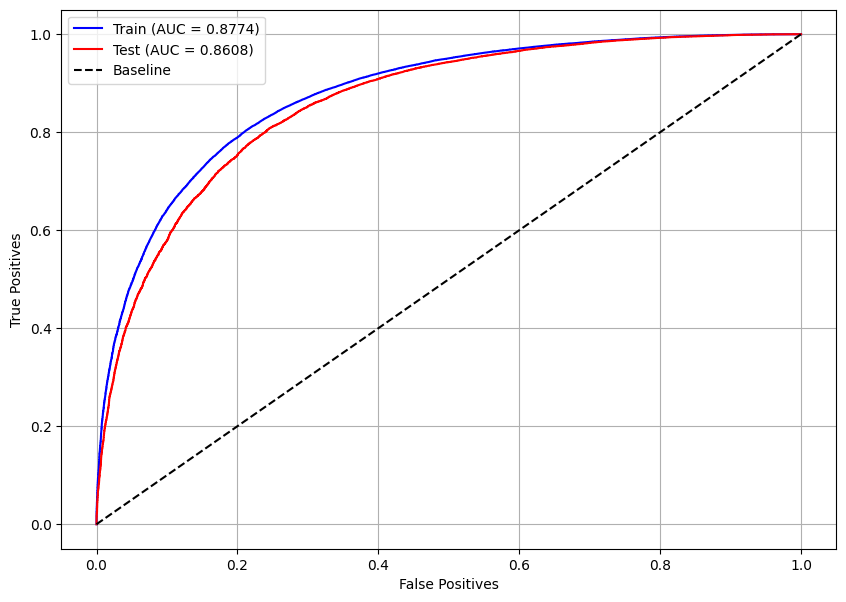

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 114,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 6,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(4.95, 5.1, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

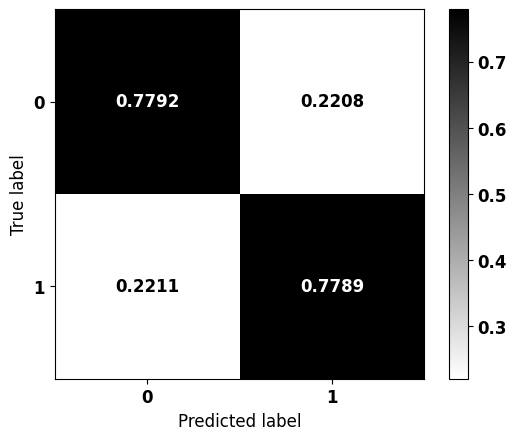


              precision    recall  f1-score   support

           0     0.4458    0.7792    0.5671      8432
           1     0.9392    0.7789    0.8516     36944

    accuracy                         0.7790     45376
   macro avg     0.6925    0.7790    0.7094     45376
weighted avg     0.8475    0.7790    0.7987     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:4.984, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

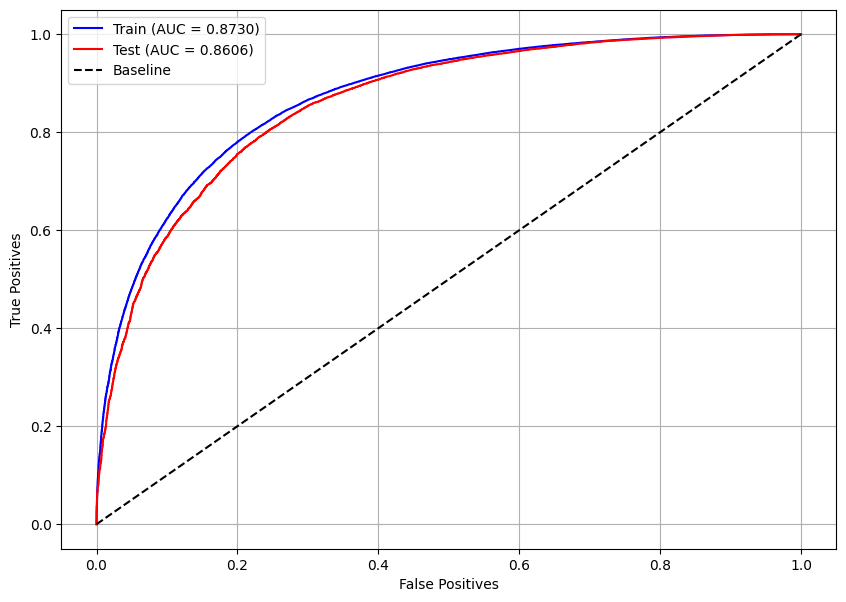

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

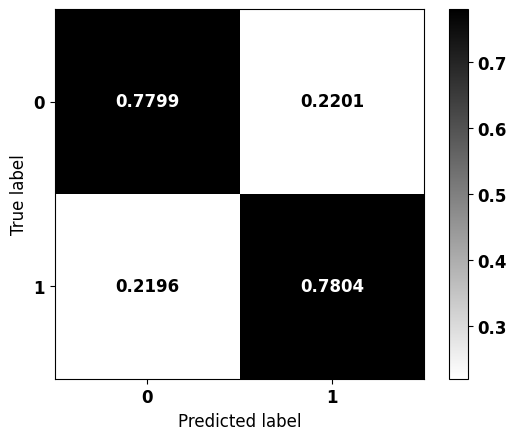


              precision    recall  f1-score   support

           0     0.4477    0.7799    0.5689      8432
           1     0.9395    0.7804    0.8526     36944

    accuracy                         0.7803     45376
   macro avg     0.6936    0.7802    0.7107     45376
weighted avg     0.8481    0.7803    0.7999     45376



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.16,
          'min_child_weight': 2, 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:5.06, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

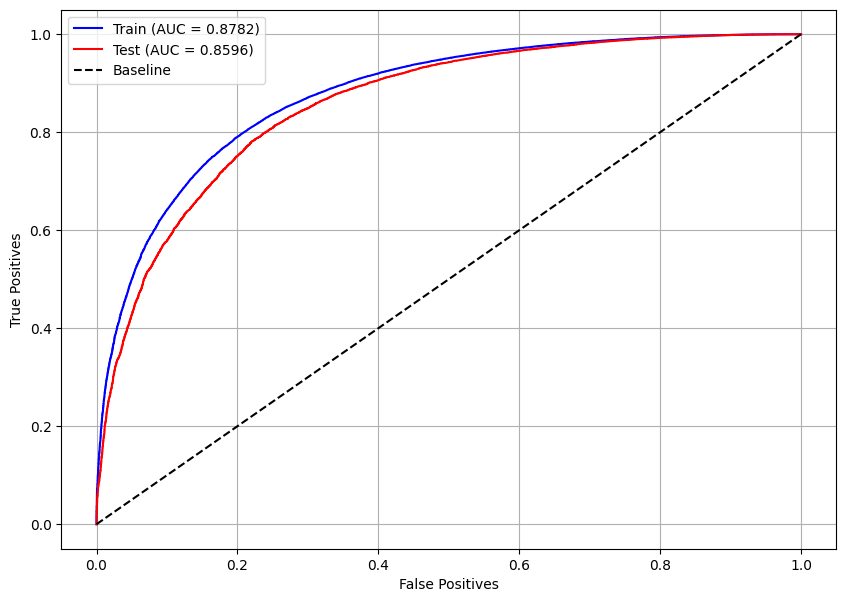

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


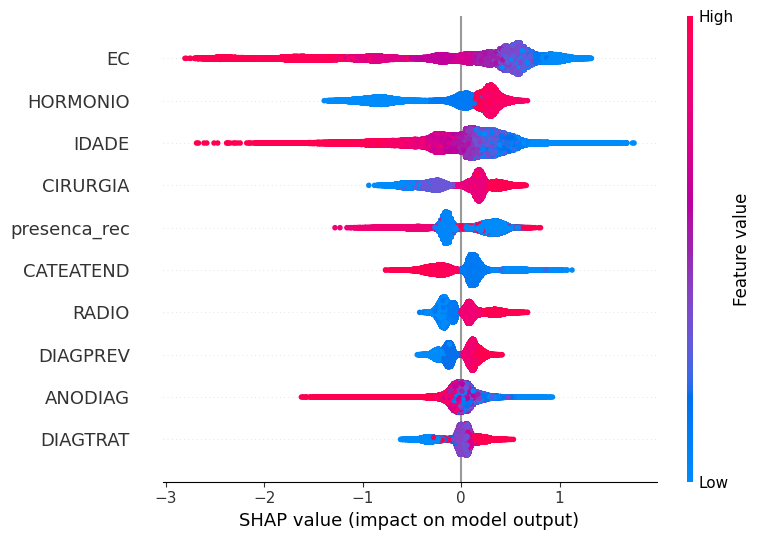

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=147, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


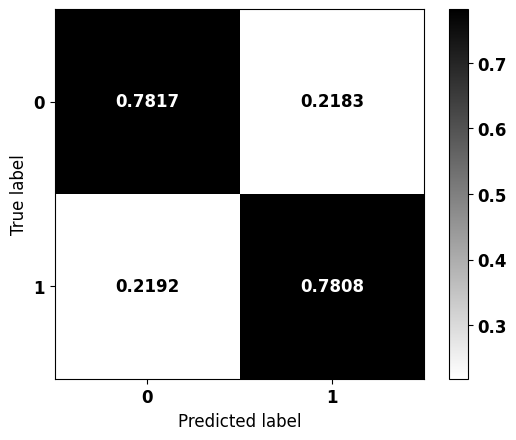


              precision    recall  f1-score   support

           0     0.4487    0.7817    0.5701      8432
           1     0.9400    0.7808    0.8530     36944

    accuracy                         0.7810     45376
   macro avg     0.6944    0.7812    0.7116     45376
weighted avg     0.8487    0.7810    0.8005     45376



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

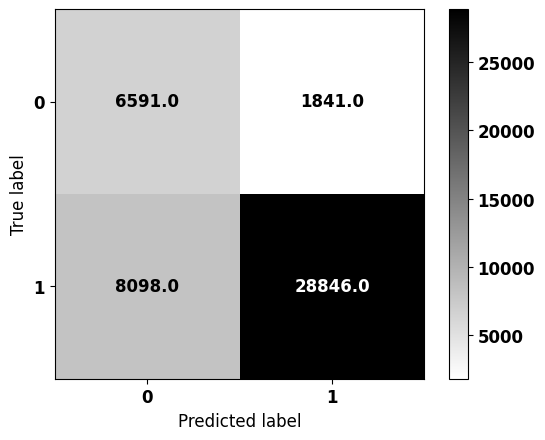


              precision    recall  f1-score   support

           0     0.4487    0.7817    0.5701      8432
           1     0.9400    0.7808    0.8530     36944

    accuracy                         0.7810     45376
   macro avg     0.6944    0.7812    0.7116     45376
weighted avg     0.8487    0.7810    0.8005     45376



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
# Mama
X_test_mama = df_mama_teste.drop(columns=list_drop).copy()
y_test_mama = df_mama_teste.sobrevida_3anos.copy()

# Próstata
X_test_prost = df_prost_teste.drop(columns=list_drop).copy()
y_test_prost = df_prost_teste.sobrevida_3anos.copy()

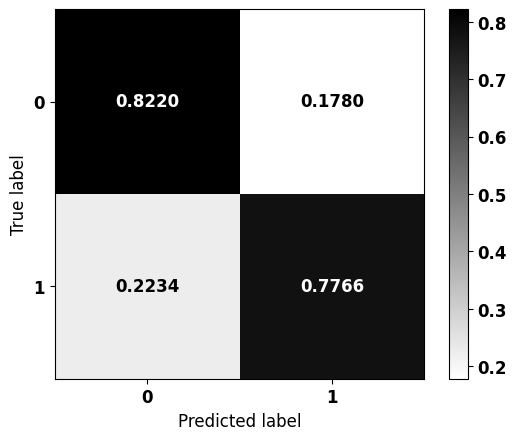


              precision    recall  f1-score   support

           0     0.4835    0.8220    0.6089      5117
           1     0.9449    0.7766    0.8525     20115

    accuracy                         0.7858     25232
   macro avg     0.7142    0.7993    0.7307     25232
weighted avg     0.8513    0.7858    0.8031     25232



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama)

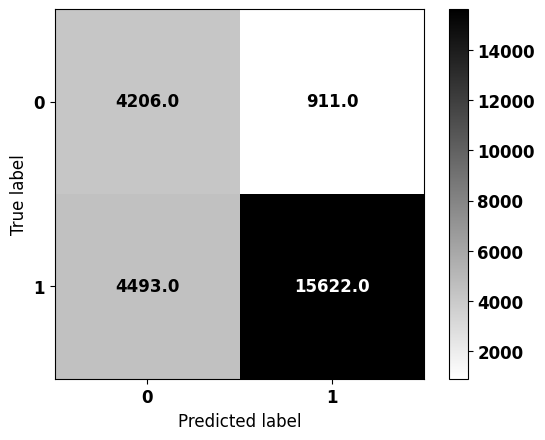


              precision    recall  f1-score   support

           0     0.4835    0.8220    0.6089      5117
           1     0.9449    0.7766    0.8525     20115

    accuracy                         0.7858     25232
   macro avg     0.7142    0.7993    0.7307     25232
weighted avg     0.8513    0.7858    0.8031     25232



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

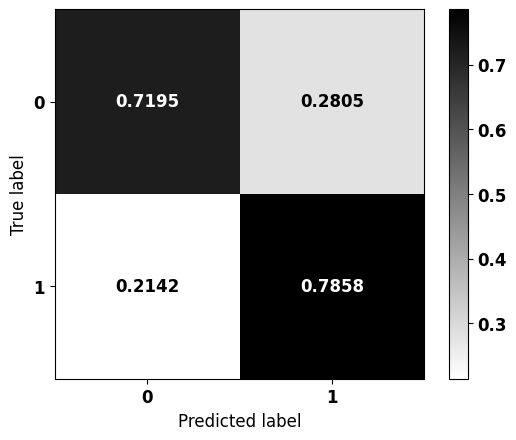


              precision    recall  f1-score   support

           0     0.3982    0.7195    0.5126      3315
           1     0.9343    0.7858    0.8536     16829

    accuracy                         0.7749     20144
   macro avg     0.6662    0.7526    0.6831     20144
weighted avg     0.8461    0.7749    0.7975     20144



In [ ]:
# Próstata
plot_confusion_matrix(best, X_test_prost, y_test_prost)

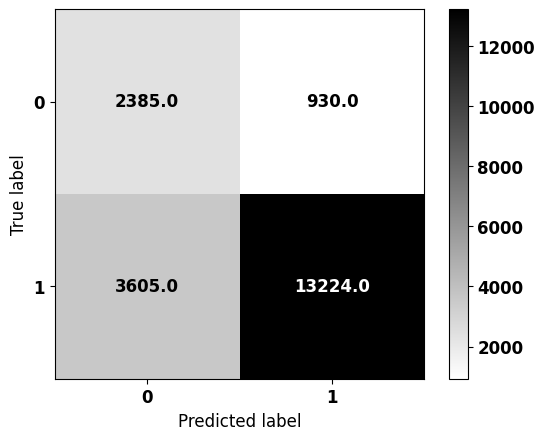


              precision    recall  f1-score   support

           0     0.3982    0.7195    0.5126      3315
           1     0.9343    0.7858    0.8536     16829

    accuracy                         0.7749     20144
   macro avg     0.6662    0.7526    0.6831     20144
weighted avg     0.8461    0.7749    0.7975     20144



In [ ]:
# Próstata
plot_confusion_matrix(best, X_test_prost, y_test_prost, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7765, Optuna = 0.7810

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7775, Optuna = 0.7803

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 5.06, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.16, max_depth=7, min_child_weight=2,
               n_estimators=150, random_state=7, verbose=-1)

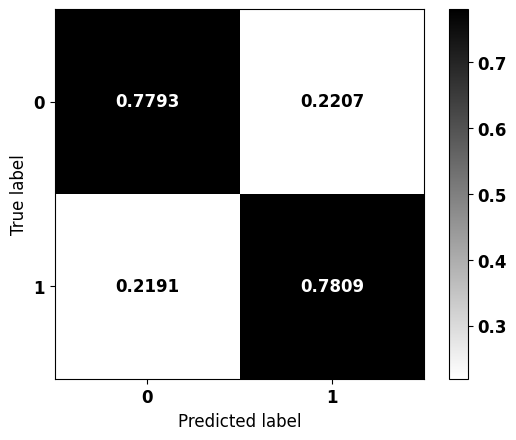


              precision    recall  f1-score   support

           0     0.4480    0.7793    0.5689      8432
           1     0.9394    0.7809    0.8528     36944

    accuracy                         0.7806     45376
   macro avg     0.6937    0.7801    0.7109     45376
weighted avg     0.8481    0.7806    0.8001     45376



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

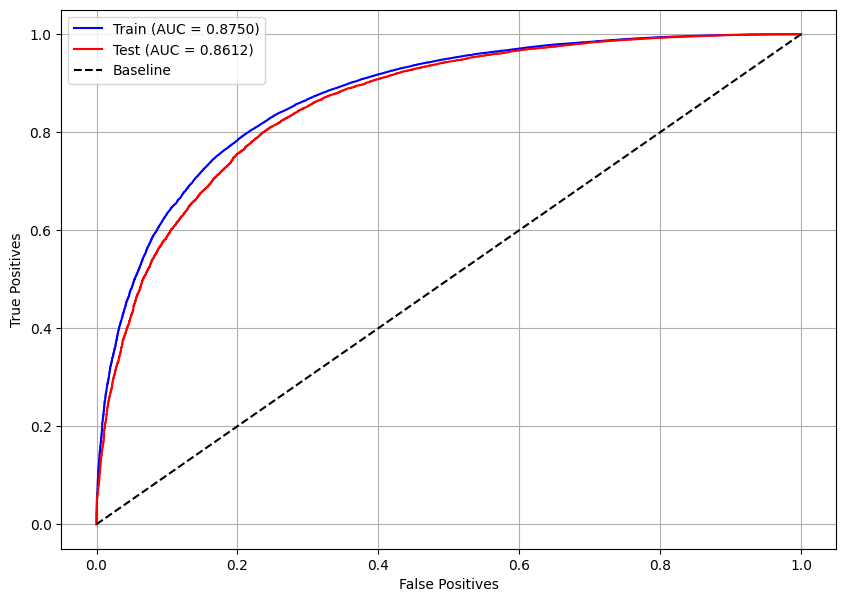

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Mama e Próstata Juntos**

**Com TOPOGRUP**

## **Dados**

In [ ]:
!gdown 17zM_C6hBXD04almLkOw_lrCVyc339T73 --quiet # Mama treino
!gdown 17yy_juIUm02TooYE6PAX2MSzM1VjvYq1 --quiet # Mama teste
!gdown 17zGad6DS9tXVTGyw56j59mIMesz8Dq83 --quiet # Próstata treino
!gdown 181kx3XNGgjKNPW7GtDC1zqtL9Hz3JDVA --quiet # Próstata teste

In [ ]:
df_mama_treino = pd.read_csv('/content/mama_treino_3anos.csv')
print(df_mama_treino.shape)
df_mama_treino.head(3)

(75693, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,1.352201,0.078023,0.855700,-0.774058,-0.898638,-1.166659,-0.137075,0.545284,1.009224,-1.542157,...,0.912401,-0.854011,-0.670762,0.745516,-0.804498,-0.017031,0.958238,-0.517314,0,1
1,0.767303,0.078023,-1.456854,-0.774058,1.112795,-1.166659,-0.137075,0.545284,-0.990860,-1.542157,...,1.288153,2.102508,1.848145,0.745516,-0.804498,-0.977651,-1.043582,-0.517314,0,1
2,-0.768055,0.078023,0.855700,1.228497,1.112795,1.722849,-0.137075,-1.833906,-0.990860,0.648443,...,-0.026978,-0.854011,-0.670762,0.745516,0.579917,0.943589,0.958238,1.933063,0,0


In [ ]:
df_prost_treino = pd.read_csv('/content/prost_treino_3anos.csv')
print(df_prost_treino.shape)
df_prost_treino.head(3)

(60432, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.082486,0.0,-0.325918,-0.716132,0.735262,0.280252,-0.26085,1.123998,-0.720286,-0.306868,...,1.506622,-0.153154,-0.153287,-1.665773,-0.970784,0.315539,-0.897949,-0.413965,1,1
1,0.260425,0.0,-0.170011,-0.716132,0.735262,1.643727,-0.26085,-0.889682,-0.720286,-0.306868,...,-0.103215,1.263510,1.280904,-0.263251,-0.970784,-0.737744,1.113649,-0.413965,1,0
2,1.289155,0.0,-1.602573,-0.716132,-1.360059,0.734744,-0.26085,-0.889682,1.388338,-0.306868,...,1.305392,1.086427,0.802840,0.457569,0.440179,0.315539,-0.897949,-0.413965,1,1


In [ ]:
from sklearn.utils import shuffle

df_mama_prost_treino = pd.concat([df_mama_treino, df_prost_treino], ignore_index=True)
df_mama_prost_treino = shuffle(df_mama_prost_treino, random_state=seed)
df_mama_prost_treino.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
82562,0.146121,0.0,1.083307,1.341668,-1.360059,1.643727,-0.26085,-0.889682,1.388338,3.258727,...,-0.706905,0.023929,1.280904,0.457569,0.440179,-0.737744,-0.897949,-0.413965,1,1
128657,0.489031,0.0,-1.596970,-1.010104,-1.360059,-1.992207,-0.26085,1.123998,-0.720286,-0.306868,...,1.707852,-0.153154,-0.153287,0.849660,0.440179,2.422104,-0.897949,-0.413965,1,0
109667,0.031818,0.0,0.933235,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,-2.115512,1.440593,0.563808,0.821102,-0.970784,-0.737744,1.113649,-0.413965,1,1


In [ ]:
df_mama_teste = pd.read_csv('/content/mama_teste_3anos.csv')
print(df_mama_teste.shape)
df_mama_teste.head(3)

(25232, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.987392,0.078023,0.855700,-0.774058,1.112795,0.484489,-0.137075,-1.833906,-0.99086,0.648443,...,1.100277,-0.854011,-0.670762,0.745516,-0.804498,0.943589,0.958238,-0.517314,0,0
1,-0.841168,0.078023,1.111192,1.228497,-0.898638,0.897275,-0.137075,-1.833906,-0.99086,0.648443,...,-1.154233,0.069902,0.016212,-0.647069,0.579917,-0.017031,-1.043582,-0.517314,0,1
2,-0.329382,0.078023,-1.833992,-0.774058,1.112795,1.722849,-0.137075,-1.833906,-0.99086,-1.542157,...,0.724526,0.624249,0.245204,-1.832726,-0.804498,1.904208,0.958238,-0.517314,0,1


In [ ]:
df_prost_teste = pd.read_csv('/content/prost_teste_3anos.csv')
print(df_prost_teste.shape)
df_prost_teste.head(3)

(20144, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.603335,0.0,-0.539878,-0.716132,0.735262,1.643727,-0.26085,-0.889682,-0.720286,-0.306868,...,0.902933,1.086427,0.802840,0.457569,0.440179,0.315539,-0.897949,2.415663,1,1
1,-0.539699,0.0,-0.551315,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,0.500474,0.201012,0.802840,-1.694331,0.440179,1.368821,-0.897949,-0.413965,1,1
2,-0.196789,0.0,1.233322,-0.716132,0.735262,-0.628732,-0.26085,1.123998,-0.720286,-0.306868,...,0.500474,0.378095,0.085745,1.116050,-0.970784,0.315539,1.113649,-0.413965,1,1


In [ ]:
df_mama_prost_teste = pd.concat([df_mama_teste, df_prost_teste], ignore_index=True)
df_mama_prost_teste = shuffle(df_mama_prost_teste, random_state=seed)
df_mama_prost_teste.head(3)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
3893,-0.110045,0.078023,-0.625664,-0.774058,-0.898638,-1.579445,-0.137075,0.545284,1.009224,-1.542157,...,-0.402729,1.732943,0.703187,-1.749643,0.579917,1.904208,-1.043582,-0.517314,0,1
28530,0.603335,0.000000,0.962290,-0.716132,-1.360059,-0.628732,-0.260850,1.123998,-0.720286,3.258727,...,0.299244,-1.038570,-0.870382,0.849660,-0.970784,1.368821,1.113649,-0.413965,1,0
11228,2.229549,0.078023,0.855700,-1.060137,-0.898638,-1.579445,-0.137075,0.545284,1.009224,0.648443,...,0.348774,-0.854011,-0.670762,0.745516,0.579917,-0.977651,0.958238,-0.517314,0,1


In [ ]:
# Valores faltantes
df_mama_prost_treino.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
TRATCONS              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
NENHUM                0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Valores faltantes
df_mama_prost_teste.isna().sum().sort_values(ascending=False)

IDADE                 0
CONSDIAG              0
TOPOGRUP              0
presenca_rec          0
IBGE_idem_IBGEATEN    0
ESCOLARI_preench      0
HABILIT2              0
IBGEATEN              0
RRAS                  0
DRS                   0
ANODIAG               0
DIAGTRAT              0
TRATCONS              0
OUTROS                0
SEXO                  0
IMUNO                 0
TMO                   0
HORMONIO              0
QUIMIO                0
RADIO                 0
CIRURGIA              0
NENHUM                0
EC                    0
DIAGPREV              0
CATEATEND             0
IBGE                  0
sobrevida_3anos       0
dtype: int64

In [ ]:
# Correlação com a saída
corr_matrix = df_mama_prost_treino.corr(numeric_only=True)
abs(corr_matrix['sobrevida_3anos']).sort_values(ascending = False).head(20)

sobrevida_3anos       1.000000
EC                    0.346180
CIRURGIA              0.225860
TRATCONS              0.147436
DIAGTRAT              0.145469
NENHUM                0.140777
IDADE                 0.131090
HORMONIO              0.123405
RADIO                 0.112039
ESCOLARI_preench      0.100464
CATEATEND             0.074137
presenca_rec          0.073588
DIAGPREV              0.066976
QUIMIO                0.058831
TOPOGRUP              0.048809
ANODIAG               0.013343
IBGE_idem_IBGEATEN    0.011967
HABILIT2              0.011486
CONSDIAG              0.010284
SEXO                  0.008204
Name: sobrevida_3anos, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_mama_prost_treino.sobrevida_3anos.value_counts()

1    110829
0     25296
Name: sobrevida_3anos, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_mama_prost_treino.drop(columns=list_drop).copy()
y_train = df_mama_prost_treino.sobrevida_3anos.copy()

# Teste
X_test = df_mama_prost_teste.drop(columns=list_drop).copy()
y_test = df_mama_prost_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((136125, 26), (136125,), (45376, 26), (45376,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

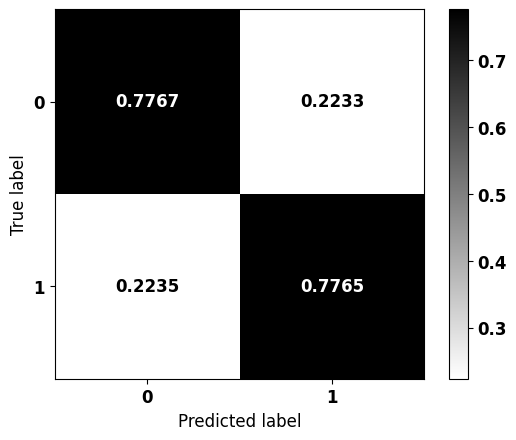


              precision    recall  f1-score   support

           0     0.4423    0.7767    0.5636      8432
           1     0.9384    0.7765    0.8498     36944

    accuracy                         0.7765     45376
   macro avg     0.6903    0.7766    0.7067     45376
weighted avg     0.8462    0.7765    0.7966     45376



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.1941,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

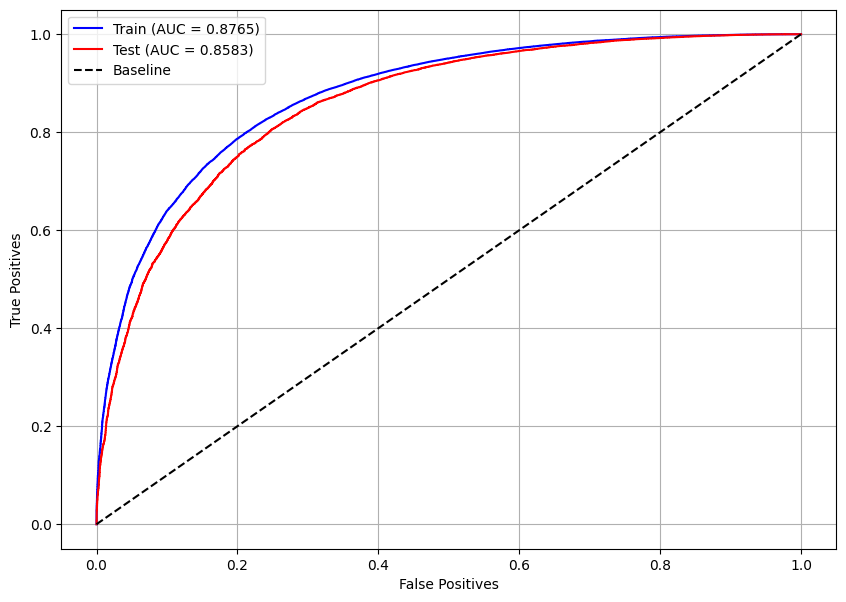

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

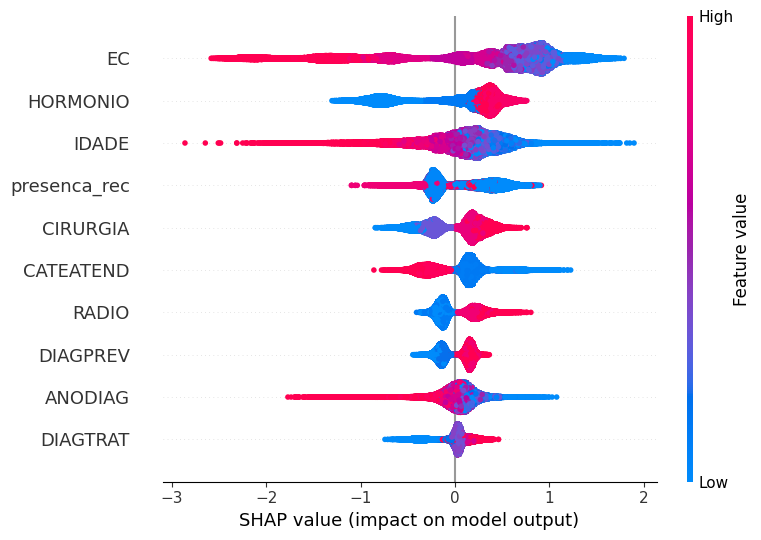

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 121,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'min_child_weight': 4,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.197, 0.199, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

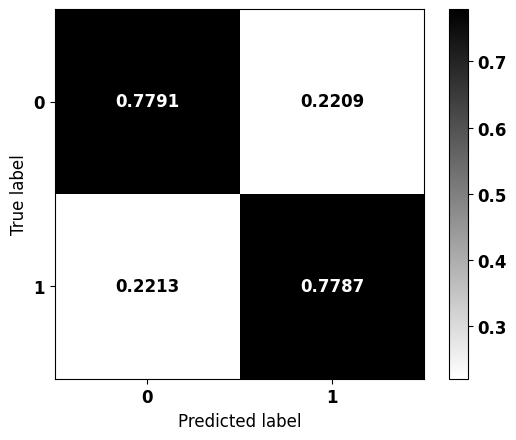


              precision    recall  f1-score   support

           0     0.4455    0.7791    0.5668      8432
           1     0.9392    0.7787    0.8514     36944

    accuracy                         0.7787     45376
   macro avg     0.6923    0.7789    0.7091     45376
weighted avg     0.8474    0.7787    0.7985     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.198

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

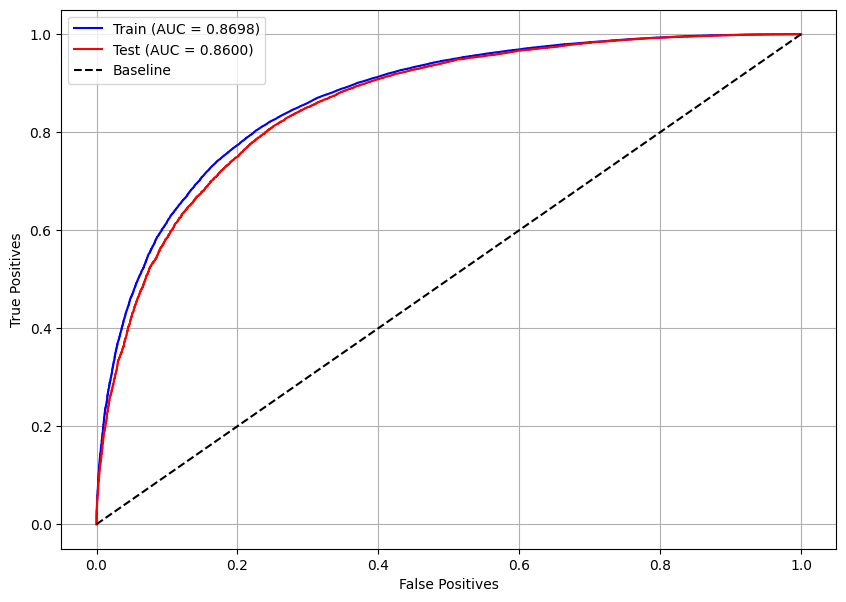

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.196, 0.199, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

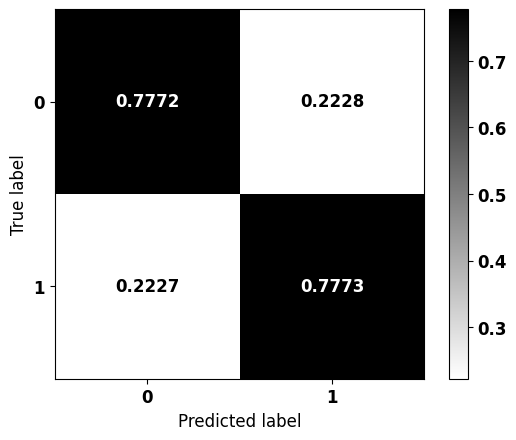


              precision    recall  f1-score   support

           0     0.4434    0.7772    0.5646      8432
           1     0.9386    0.7773    0.8504     36944

    accuracy                         0.7773     45376
   macro avg     0.6910    0.7772    0.7075     45376
weighted avg     0.8466    0.7773    0.7973     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1966

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

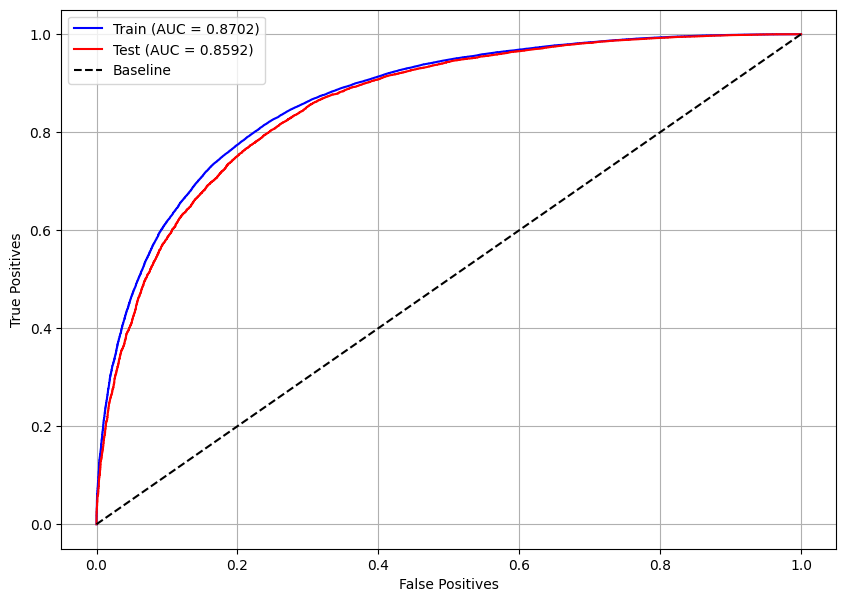

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 143,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 2,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(0.197, 0.200, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

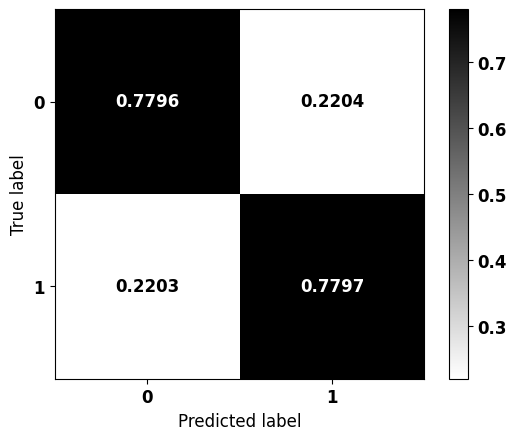


              precision    recall  f1-score   support

           0     0.4468    0.7796    0.5681      8432
           1     0.9394    0.7797    0.8521     36944

    accuracy                         0.7797     45376
   macro avg     0.6931    0.7797    0.7101     45376
weighted avg     0.8479    0.7797    0.7993     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.1971

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

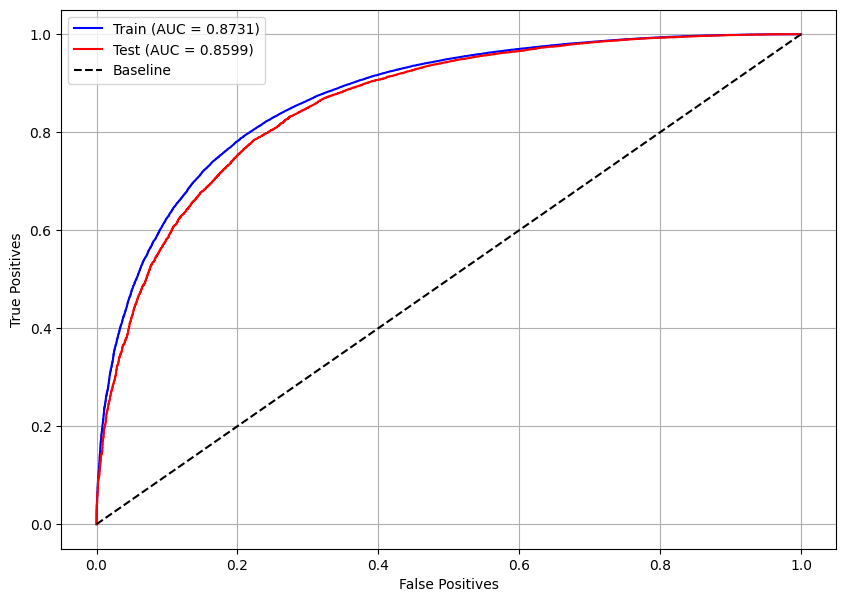

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

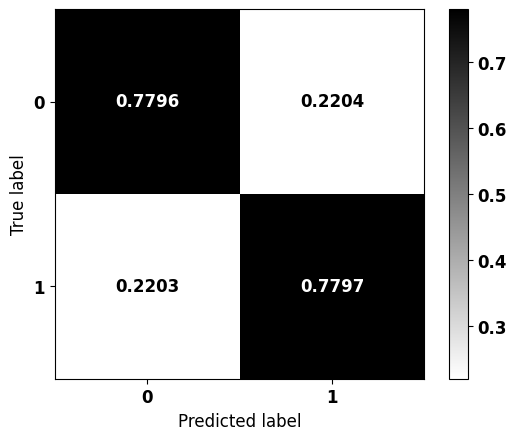


              precision    recall  f1-score   support

           0     0.4468    0.7796    0.5681      8432
           1     0.9394    0.7797    0.8521     36944

    accuracy                         0.7797     45376
   macro avg     0.6931    0.7797    0.7101     45376
weighted avg     0.8479    0.7797    0.7993     45376



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.2,
          'gamma': 0.2, 'min_child_weight': 2, 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 0.1971

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

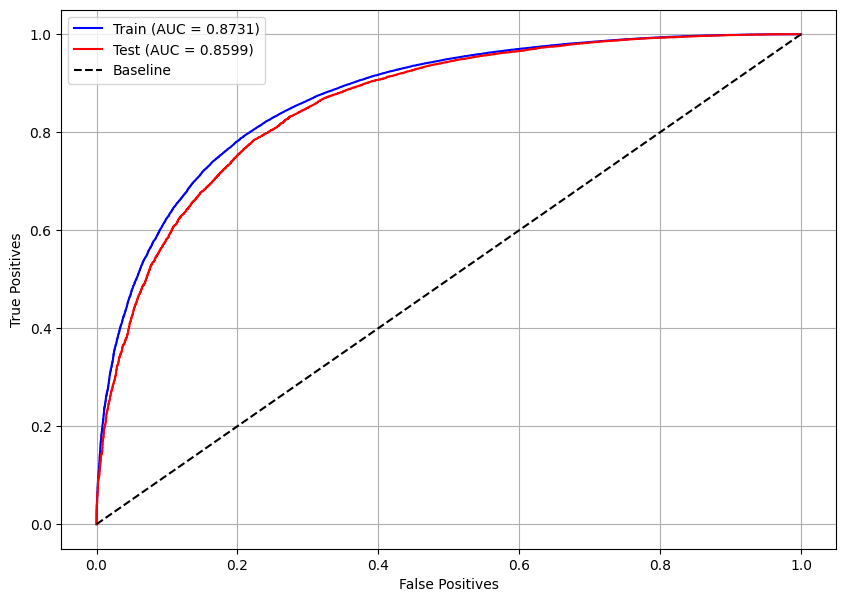

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

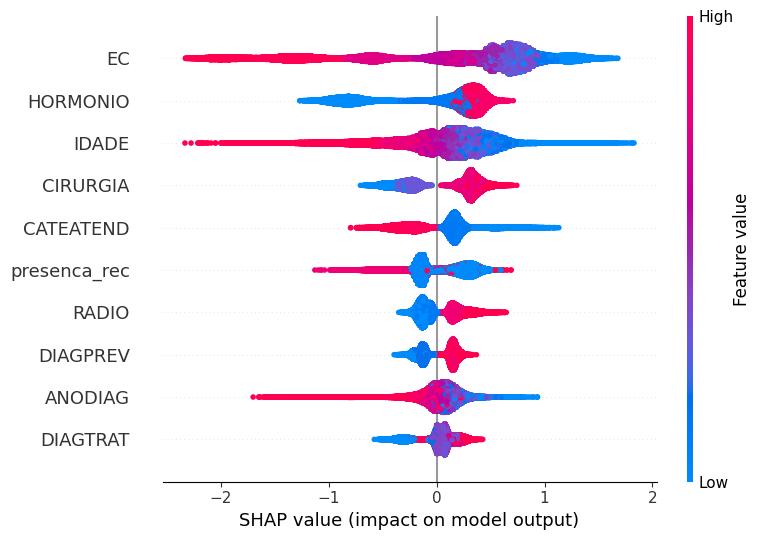

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

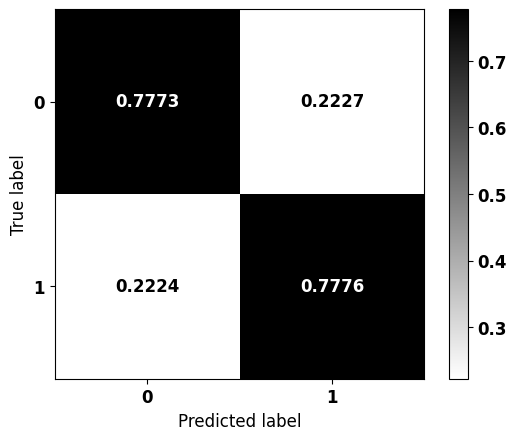


              precision    recall  f1-score   support

           0     0.4437    0.7773    0.5649      8432
           1     0.9386    0.7776    0.8505     36944

    accuracy                         0.7775     45376
   macro avg     0.6912    0.7774    0.7077     45376
weighted avg     0.8467    0.7775    0.7975     45376



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:4.94, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

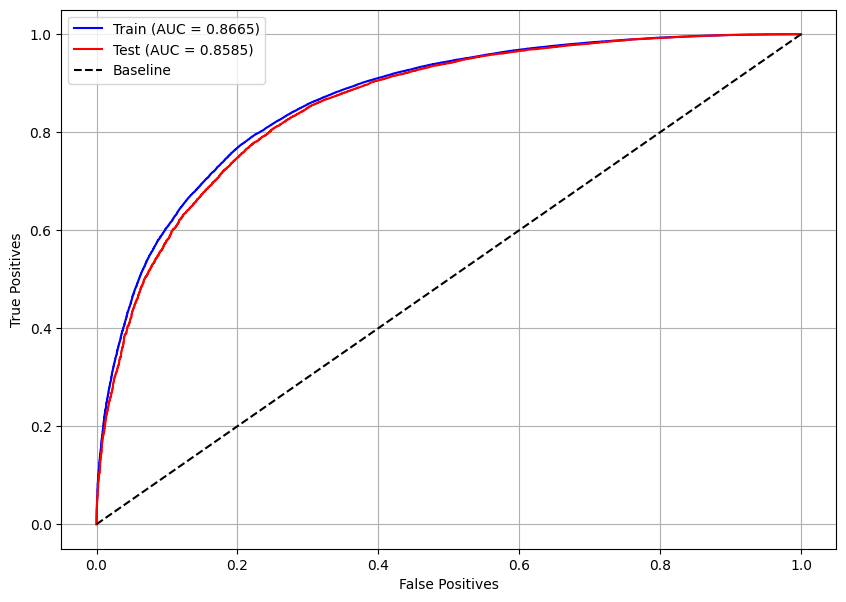

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


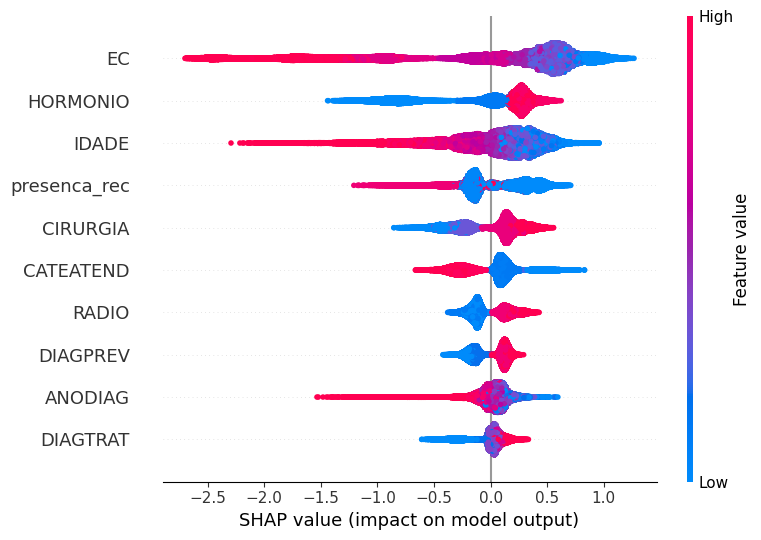

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 147,
 'max_depth': 10,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(5.1, 5.25, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

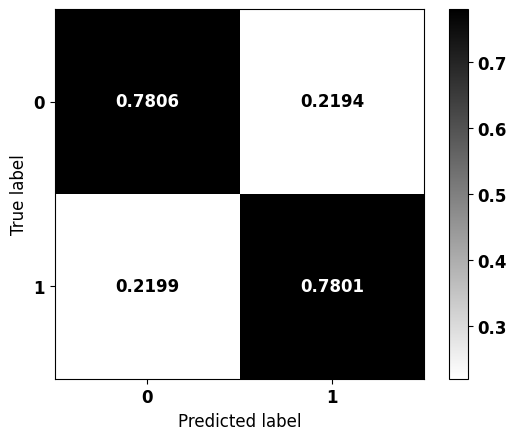


              precision    recall  f1-score   support

           0     0.4475    0.7806    0.5689      8432
           1     0.9397    0.7801    0.8525     36944

    accuracy                         0.7802     45376
   macro avg     0.6936    0.7803    0.7107     45376
weighted avg     0.8482    0.7802    0.7998     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.154, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

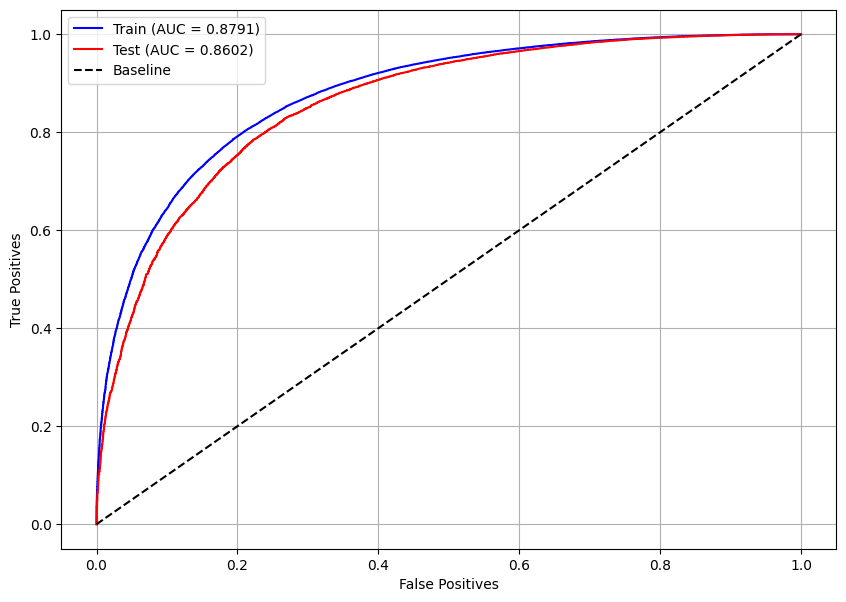

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 145,
 'max_depth': 9,
 'learning_rate': 0.13,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(5.05, 5.2, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

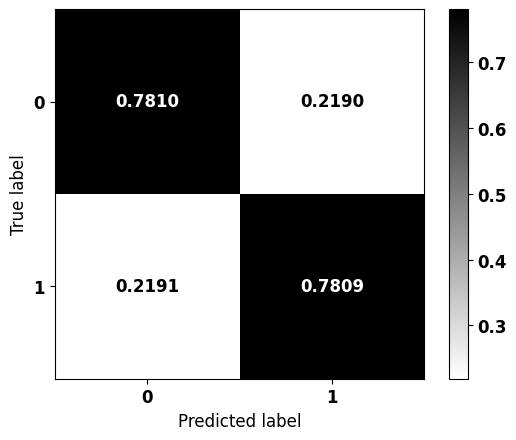


              precision    recall  f1-score   support

           0     0.4486    0.7810    0.5699      8432
           1     0.9398    0.7809    0.8530     36944

    accuracy                         0.7809     45376
   macro avg     0.6942    0.7809    0.7114     45376
weighted avg     0.8485    0.7809    0.8004     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.054, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

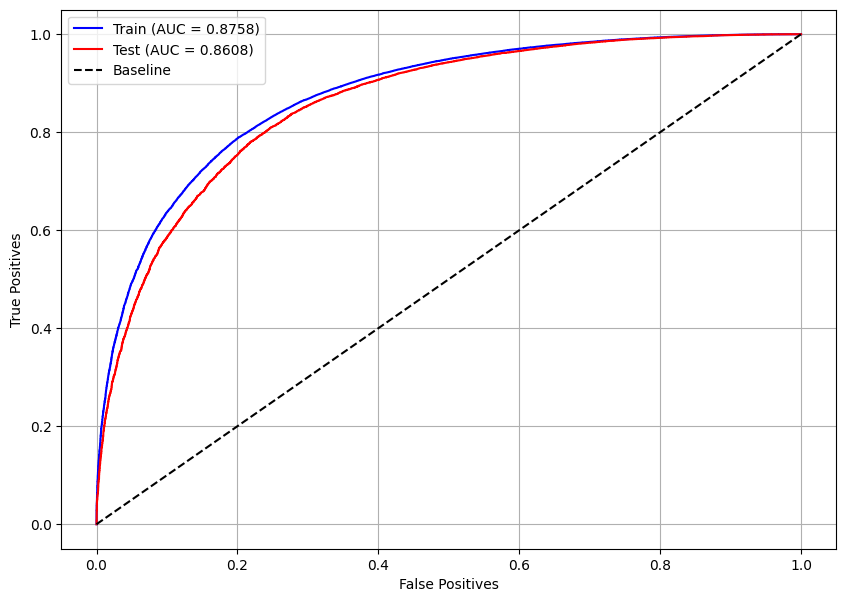

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
!pip install cmaes

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 133,
 'max_depth': 8,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(5, 5.15, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

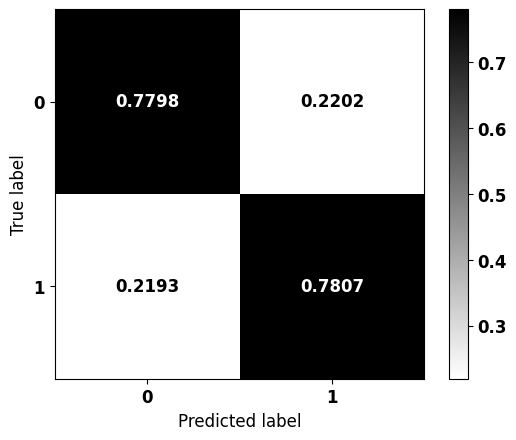


              precision    recall  f1-score   support

           0     0.4480    0.7798    0.5690      8432
           1     0.9395    0.7807    0.8528     36944

    accuracy                         0.7805     45376
   macro avg     0.6937    0.7802    0.7109     45376
weighted avg     0.8482    0.7805    0.8000     45376



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:5.109, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

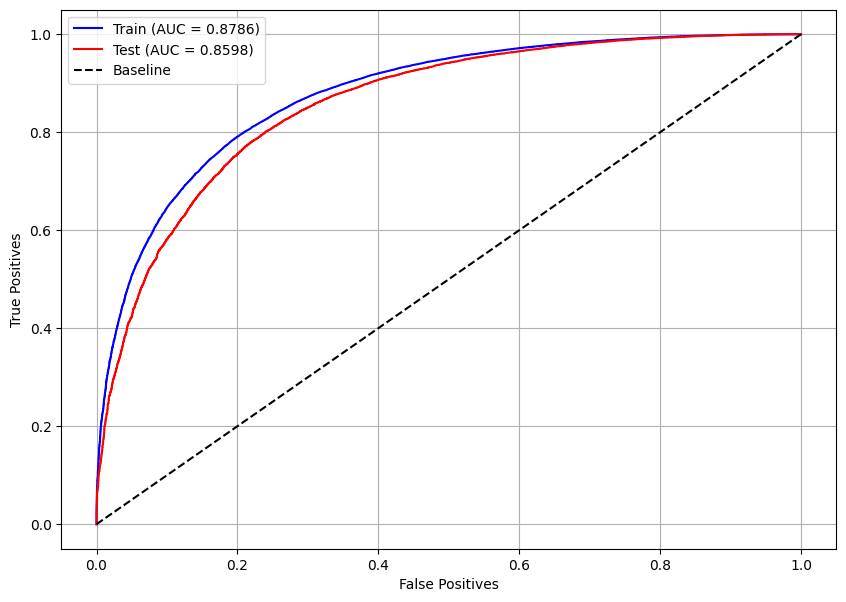

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

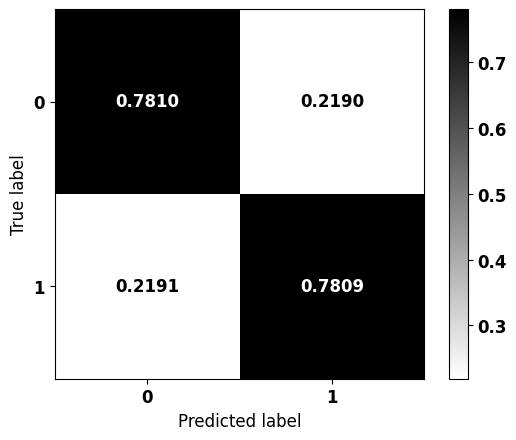


              precision    recall  f1-score   support

           0     0.4486    0.7810    0.5699      8432
           1     0.9398    0.7809    0.8530     36944

    accuracy                         0.7809     45376
   macro avg     0.6942    0.7809    0.7114     45376
weighted avg     0.8485    0.7809    0.8004     45376



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 145, 'max_depth': 9, 'learning_rate': 0.13,
          'min_child_weight': 7, 'colsample_bytree': 0.7}

params['random_state'] = seed
params['class_weight'] = {0:5.054, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

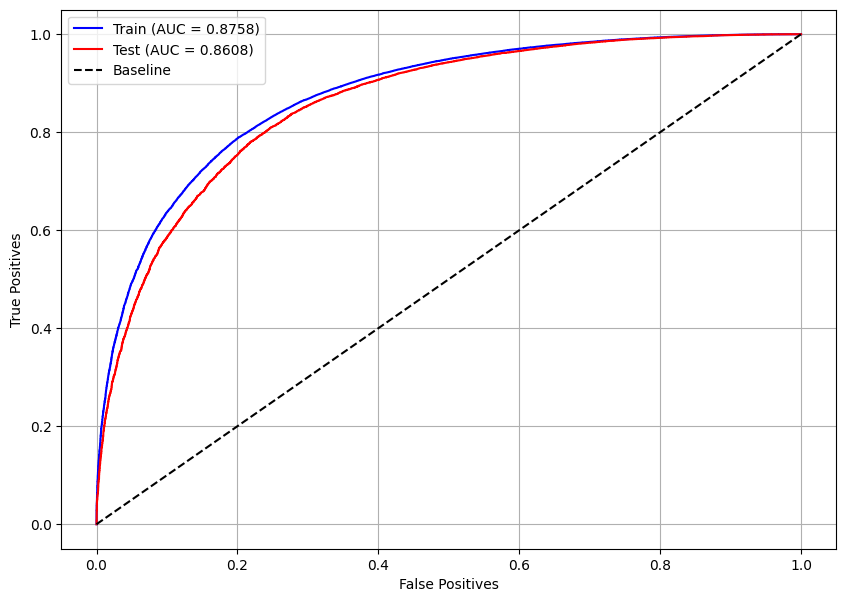

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

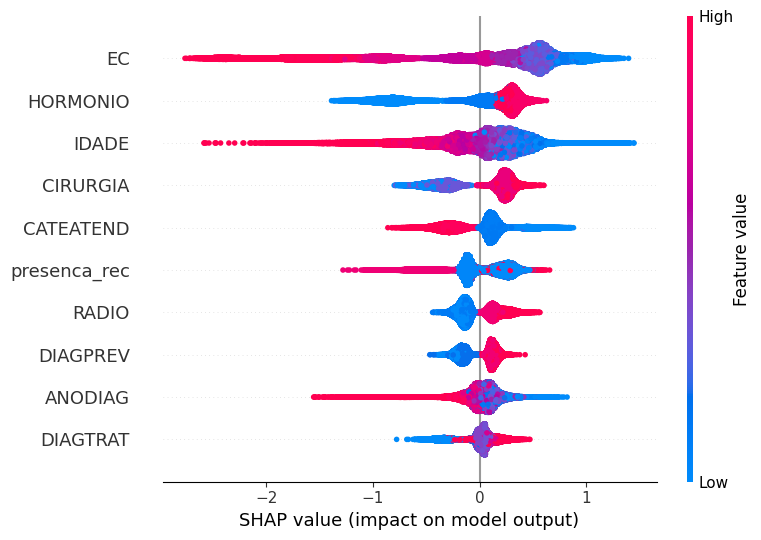

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 5.054, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.13, max_depth=9, min_child_weight=7,
               n_estimators=145, random_state=7, verbose=-1)


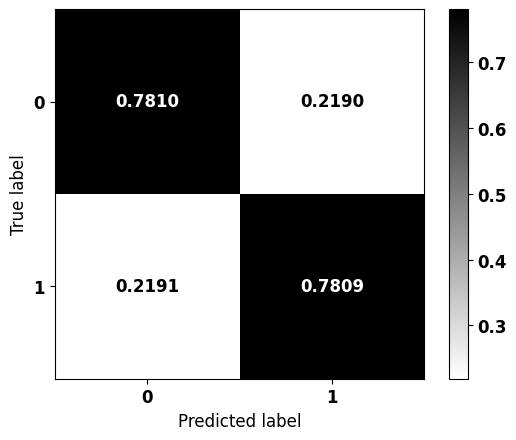


              precision    recall  f1-score   support

           0     0.4486    0.7810    0.5699      8432
           1     0.9398    0.7809    0.8530     36944

    accuracy                         0.7809     45376
   macro avg     0.6942    0.7809    0.7114     45376
weighted avg     0.8485    0.7809    0.8004     45376



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

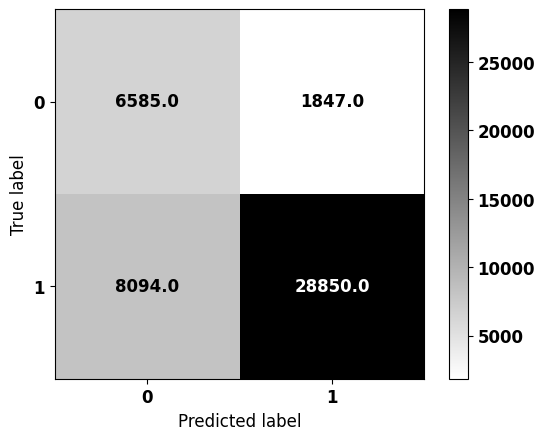


              precision    recall  f1-score   support

           0     0.4486    0.7810    0.5699      8432
           1     0.9398    0.7809    0.8530     36944

    accuracy                         0.7809     45376
   macro avg     0.6942    0.7809    0.7114     45376
weighted avg     0.8485    0.7809    0.8004     45376



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
# Mama
X_test_mama = df_mama_teste.drop(columns=list_drop).copy()
y_test_mama = df_mama_teste.sobrevida_3anos.copy()

# Próstata
X_test_prost = df_prost_teste.drop(columns=list_drop).copy()
y_test_prost = df_prost_teste.sobrevida_3anos.copy()

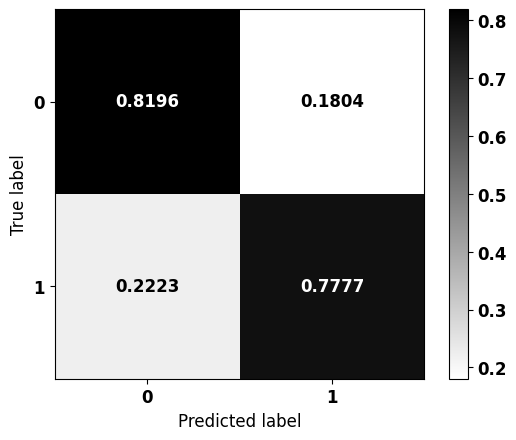


              precision    recall  f1-score   support

           0     0.4840    0.8196    0.6086      5117
           1     0.9443    0.7777    0.8530     20115

    accuracy                         0.7862     25232
   macro avg     0.7142    0.7987    0.7308     25232
weighted avg     0.8509    0.7862    0.8034     25232



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama)

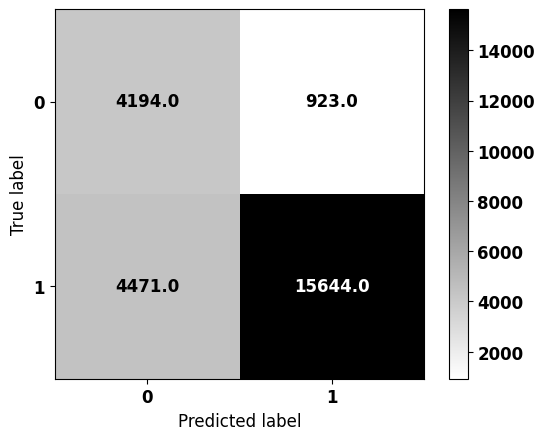


              precision    recall  f1-score   support

           0     0.4840    0.8196    0.6086      5117
           1     0.9443    0.7777    0.8530     20115

    accuracy                         0.7862     25232
   macro avg     0.7142    0.7987    0.7308     25232
weighted avg     0.8509    0.7862    0.8034     25232



In [ ]:
# Mama
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

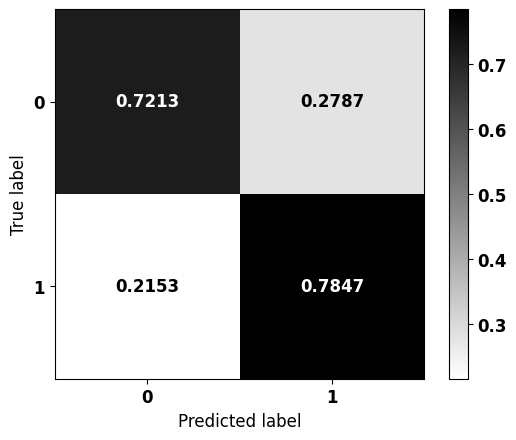


              precision    recall  f1-score   support

           0     0.3976    0.7213    0.5126      3315
           1     0.9346    0.7847    0.8531     16829

    accuracy                         0.7743     20144
   macro avg     0.6661    0.7530    0.6829     20144
weighted avg     0.8462    0.7743    0.7971     20144



In [ ]:
# Próstata
plot_confusion_matrix(best, X_test_prost, y_test_prost)

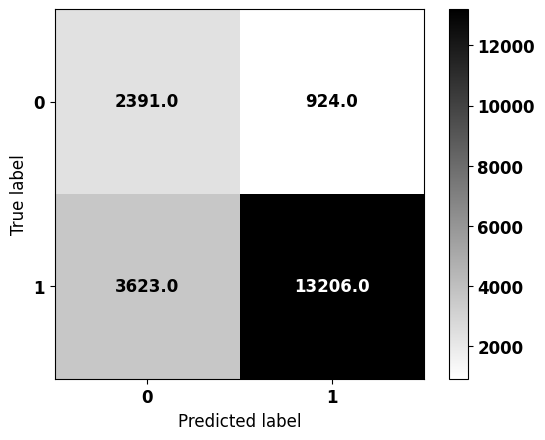


              precision    recall  f1-score   support

           0     0.3976    0.7213    0.5126      3315
           1     0.9346    0.7847    0.8531     16829

    accuracy                         0.7743     20144
   macro avg     0.6661    0.7530    0.6829     20144
weighted avg     0.8462    0.7743    0.7971     20144



In [ ]:
# Próstata
plot_confusion_matrix(best, X_test_prost, y_test_prost, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7765, Optuna = 0.7797

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7775, Optuna = 0.7809

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 5.054, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.13, max_depth=9, min_child_weight=7,
               n_estimators=145, random_state=7, verbose=-1)

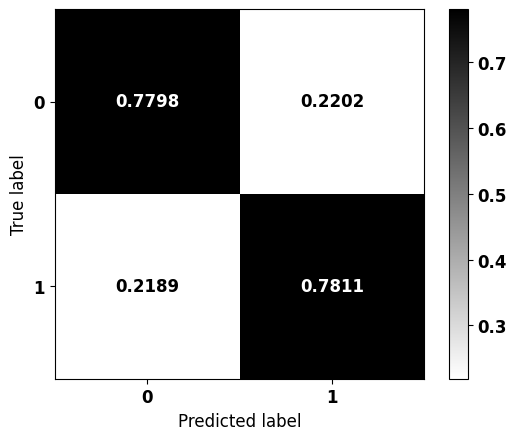


              precision    recall  f1-score   support

           0     0.4485    0.7798    0.5694      8432
           1     0.9395    0.7811    0.8530     36944

    accuracy                         0.7809     45376
   macro avg     0.6940    0.7804    0.7112     45376
weighted avg     0.8483    0.7809    0.8003     45376



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

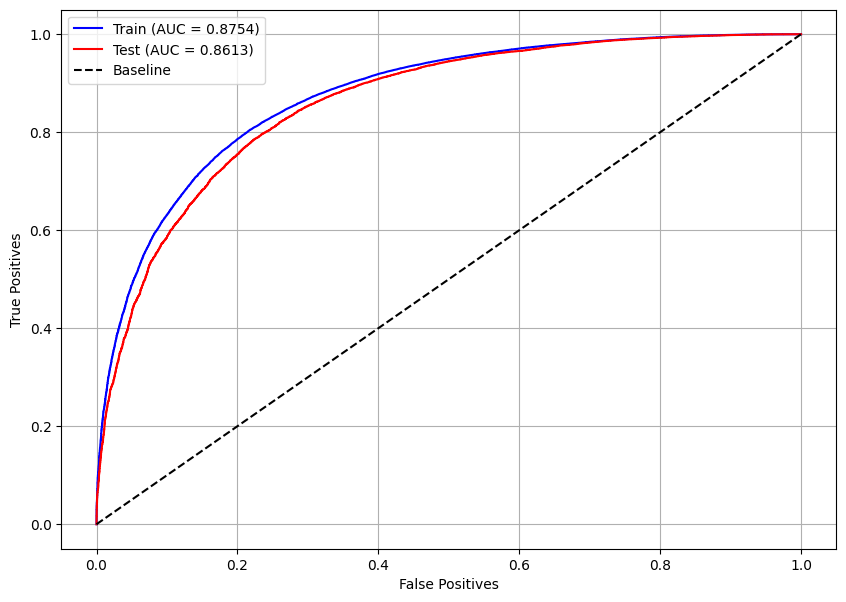

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **RN**

### **Importação das bibliotecas e funções**

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Add, Input, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Definição de cores para gráficos
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_metrics(history):
    """Plot metrics after training the RNA.

    :param history: RNA training history.

    :return: no value
    :rtype: none
    """
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+ metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        if metric == 'accuracy':
            plt.ylim([0.7, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()

### **Criação e treinamento da RNA Complexa**

In [ ]:
y_train.value_counts()

1    110829
0     25296
Name: sobrevida_3anos, dtype: int64

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Exemplos:\n Total: {total}\n Positivos: {pos} ({100*pos/total:.2f}% do total)')

# Cálculo dos pesos das duas classe
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

# Dicionário de pesos das classes para treinamento
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Peso da classe 0: {:.2f}'.format(weight_for_0))
print('Peso da classe 1: {:.2f}'.format(weight_for_1))

Exemplos:
 Total: 136125
 Positivos: 110829 (81.42% do total)
Peso da classe 0: 2.69
Peso da classe 1: 0.61


In [ ]:
input_shape = X_train.shape[1:]
input_features = Input(shape=input_shape, name='input_features')

x1 = Dense(128, activation='tanh', kernel_regularizer=l2())(input_features)
x2 = Dense(128, activation='selu', kernel_regularizer=l2())(input_features)
x3 = Dense(128, activation='sigmoid', kernel_regularizer=l2())(input_features)

from tensorflow.keras.layers import Concatenate
x_concat = Concatenate()([x1, x2, x3, input_features])

x4 = Dense(32, activation='relu', kernel_regularizer=l2())(x_concat)
out = Dense(1, activation='sigmoid', name='out_dense')(x4)

model = keras.Model(inputs=[input_features],
                    outputs=[out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 26)]                 0         []                            
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 128)                  3456      ['input_features[0][0]']      
                                                                                                  
 dense_1 (Dense)             (None, 128)                  3456      ['input_features[0][0]']      
                                                                                                  
 dense_2 (Dense)             (None, 128)                  3456      ['input_features[0][0]']  

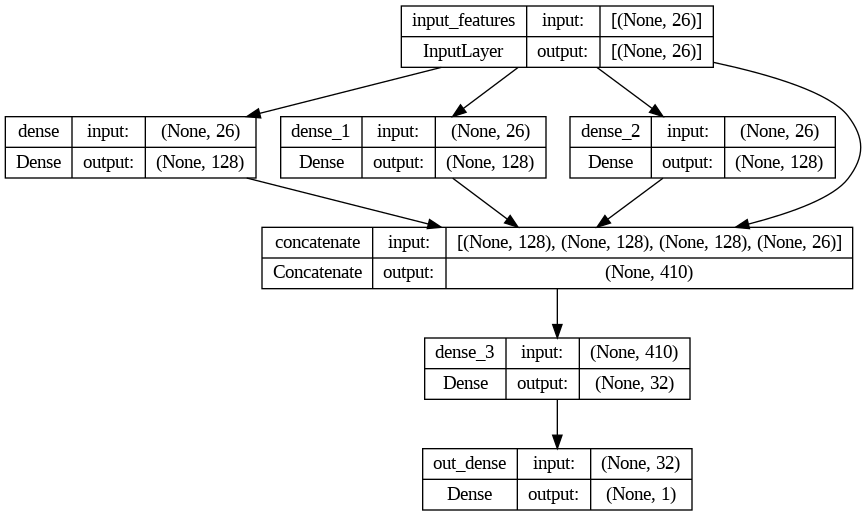

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train, y_train, epochs=50,
                    class_weight=class_weight,
                    verbose=2, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[call_es])

**Resultados**

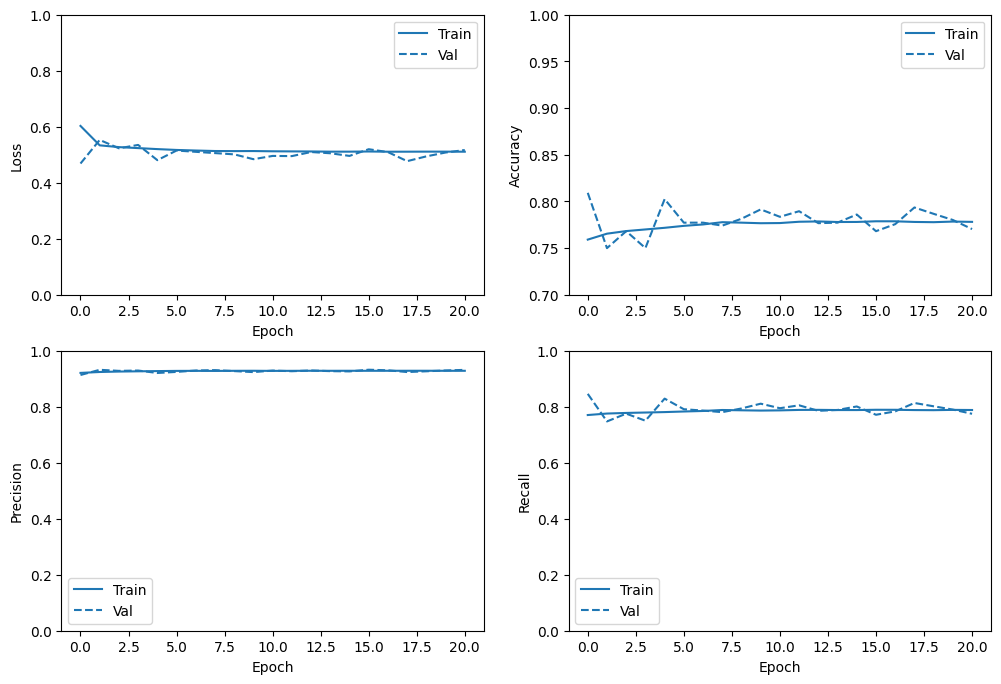

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(f'{name}: {value:.4f}')

1418/1418 [==============================] - 2s 1ms/step
Número de exemplos positivos do conjunto de teste = 36944
loss: 0.4685
accuracy: 0.8092
precision: 0.9133
recall: 0.8460
auc: 0.8264


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8783


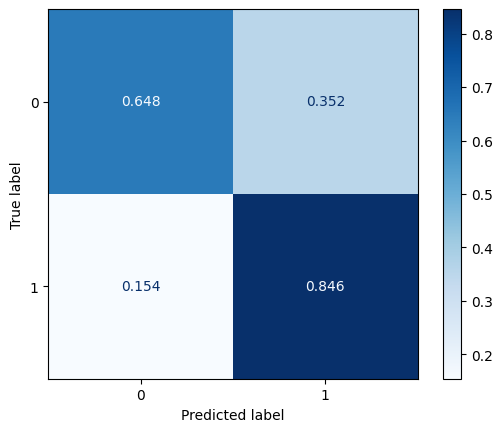

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

789/789 [==============================] - 1s 1ms/step


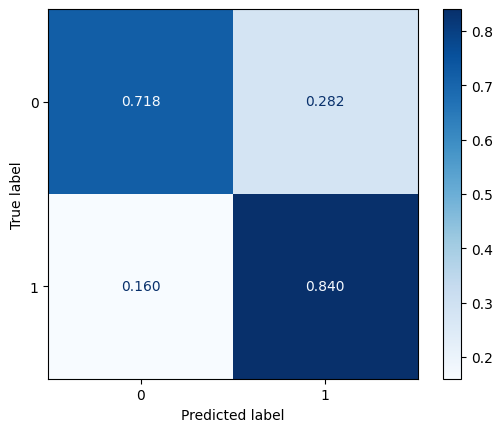

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_mama, np.round(model.predict(X_test_mama)),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

630/630 [==============================] - 1s 1ms/step


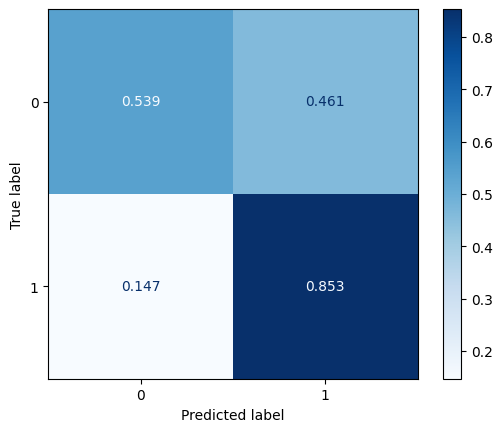

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_prost, np.round(model.predict(X_test_prost)),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.7469818158546336

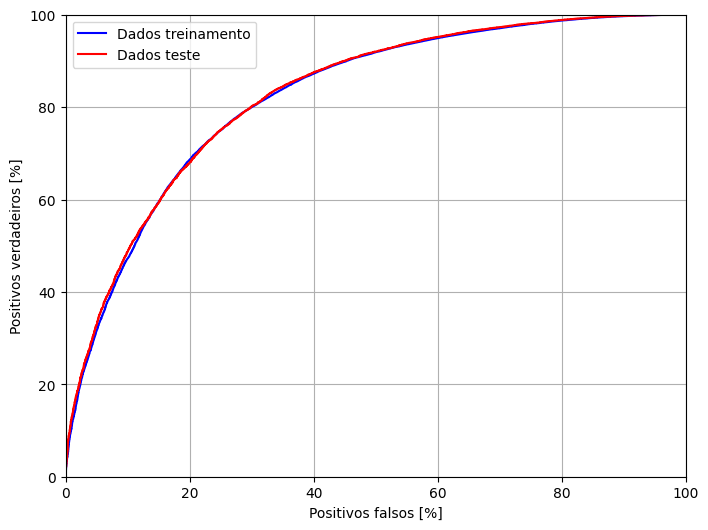

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = model.evaluate(X_train, y_train)
# custo_e_metricas_val = rna_reg.evaluate(X_val_norm, y_val)
custo_e_metricas_test = model.evaluate(X_test, y_test)

1418/1418 [==============================] - 2s 1ms/step - loss: 0.4685 - accuracy: 0.8092 - precision: 0.9133 - recall: 0.8460 - auc: 0.8264


### **Criação e treinamento da RNA Residual**

In [ ]:
# Função que cria o bloco para a RN residual
def bloco_residual(x, n):

    z1 = Dense(n, activation='relu')(x)
    z2 = Dense(n)(z1)
    sum = Add()([x, z2])
    a2 = Activation('relu')(sum)

    return a2

In [ ]:
# Definição da entrada
input_shape = X_train.shape[1:]
input_features = Input(shape=input_shape)

X1 = Dense(128, activation='relu')(input_features)

X2 = bloco_residual(X1, 128)

X3 = Dense(128, activation='relu')(X2)

X4 = bloco_residual(X3, 128)

X5 = Dense(32, activation='relu')(X4)

X6 = bloco_residual(X5, 32)

X7 = Dense(16, activation='relu')(X6)

Y = Dense(units=1, activation='sigmoid')(X7)

# Criação da RNA
rna = Model(input_features, Y)

# Mostra resumo da RNA
rna.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 128)                  3456      ['input_1[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 128)                  16512     ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 128)                  16512     ['dense_5[0][0]']             
                                                                                            

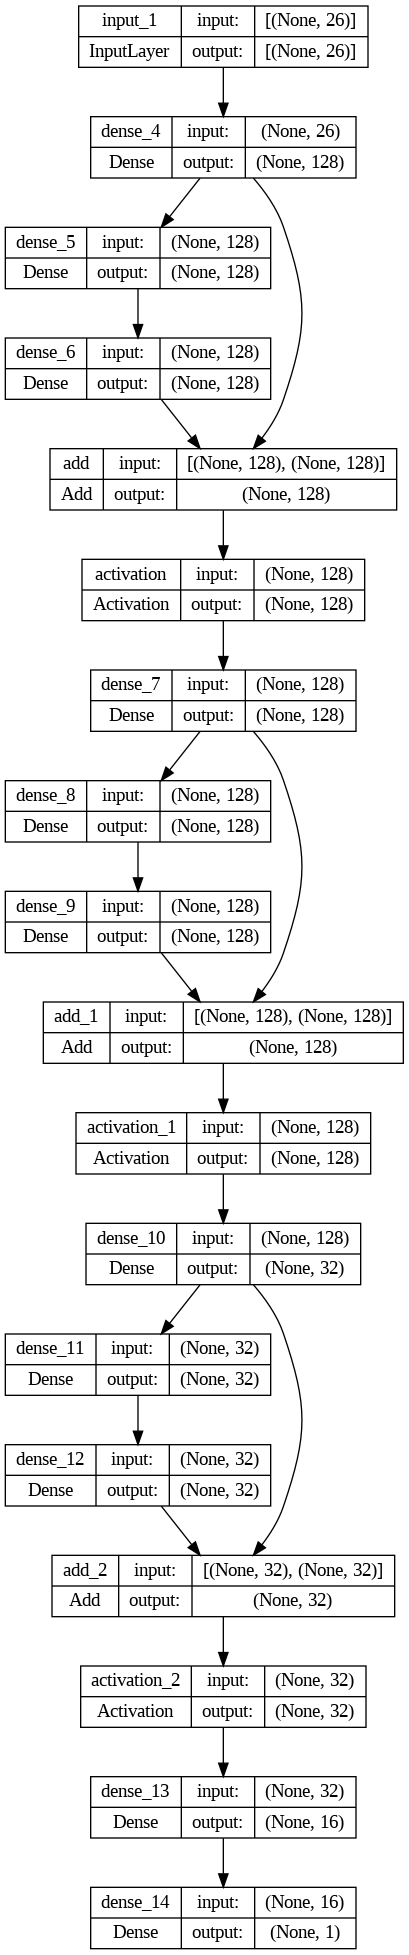

In [ ]:
keras.utils.plot_model(rna, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20,
                        restore_best_weights=True)

adam = Adam(learning_rate=0.001)
rna.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=METRICS)

history = rna.fit(X_train, y_train, epochs=50,
                    class_weight=class_weight,
                    verbose=2, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[call_es])

**Resultados**

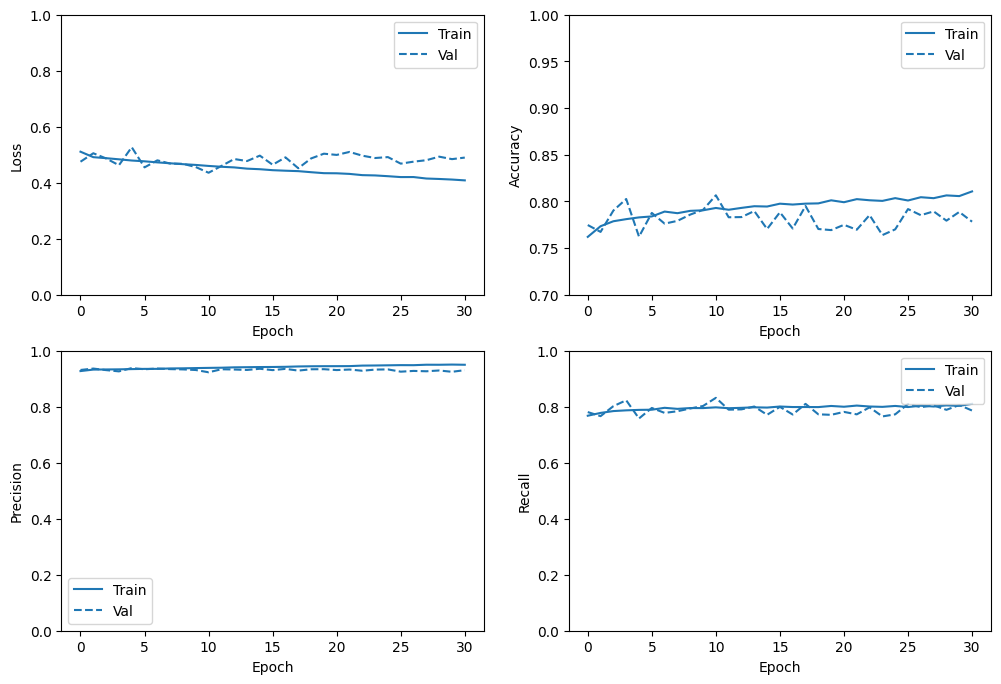

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = rna.predict(X_train)
test_pred = rna.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = rna.evaluate(X_test, y_test, verbose=0)

for name, value in zip(rna.metrics_names, results):
    print(f'{name}: {value:.4f}')

1418/1418 [==============================] - 2s 1ms/step
Número de exemplos positivos do conjunto de teste = 36944
loss: 0.4356
accuracy: 0.8065
precision: 0.9230
recall: 0.8317
auc: 0.8469


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8750


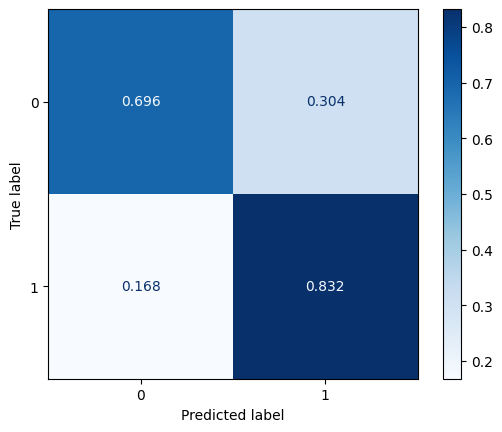

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.7638785878704155

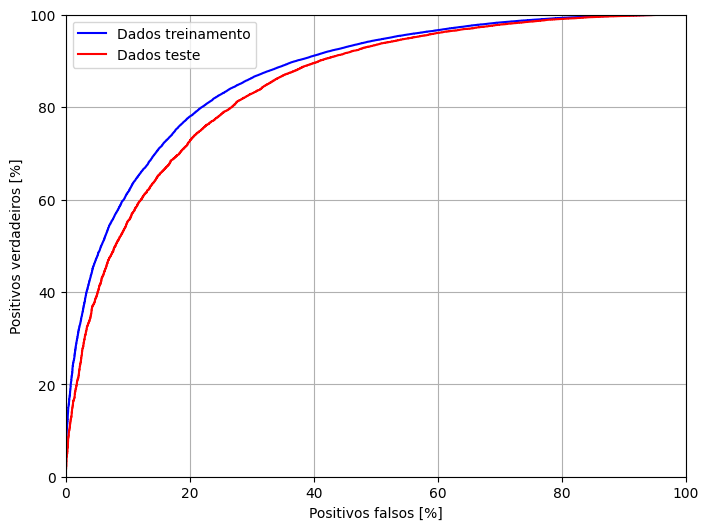

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = rna.evaluate(X_train, y_train)
custo_e_metricas_test = rna.evaluate(X_test, y_test)

1418/1418 [==============================] - 2s 2ms/step - loss: 0.4356 - accuracy: 0.8065 - precision: 0.9230 - recall: 0.8317 - auc: 0.8469


### **Criação e treinamento da RNA Sequencial**

In [ ]:
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Exemplos:\n Total: {total}\n Positivos: {pos} ({100*pos/total:.2f}% do total)')

# Cálculo dos pesos das duas classe
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

# Dicionário de pesos das classes para treinamento
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Peso da classe 0: {:.2f}'.format(weight_for_0))
print('Peso da classe 1: {:.2f}'.format(weight_for_1))

Exemplos:
 Total: 136125
 Positivos: 110829 (81.42% do total)
Peso da classe 0: 2.69
Peso da classe 1: 0.61


In [ ]:
rna = Sequential()
rna.add(Dense(units=256, activation='relu', input_shape=X_train.shape[1:]))
rna.add(Dense(units=128, activation='relu'))
rna.add(Dense(units=128, activation='relu'))
rna.add(Dense(units=128, activation='relu'))
rna.add(Dense(units=64, activation='relu'))
rna.add(Dense(units=1, activation='sigmoid'))
rna.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               6912      
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 81153 (317.00 KB)
Trainable params: 81153 

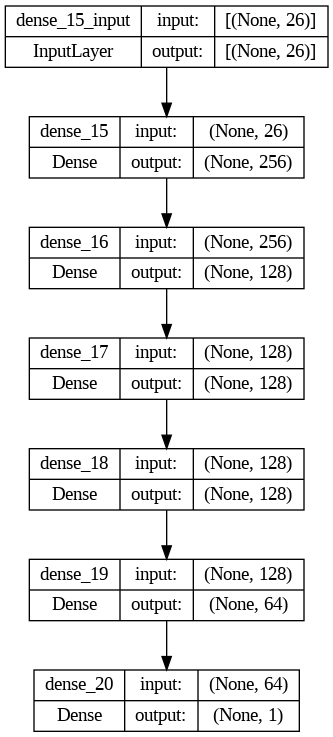

In [ ]:
keras.utils.plot_model(rna, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define métricas
METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

call_es = EarlyStopping(monitor='val_loss', patience=20,
                        restore_best_weights=True)

adam = Adam(learning_rate=0.001)
rna.compile(optimizer=adam, loss='binary_crossentropy',
            metrics=METRICS)

history = rna.fit(X_train, y_train, epochs=50,
                  class_weight=class_weight,
                  verbose=2, batch_size=32,
                  validation_data=(X_test, y_test),
                  callbacks=[call_es])

**Resultados**

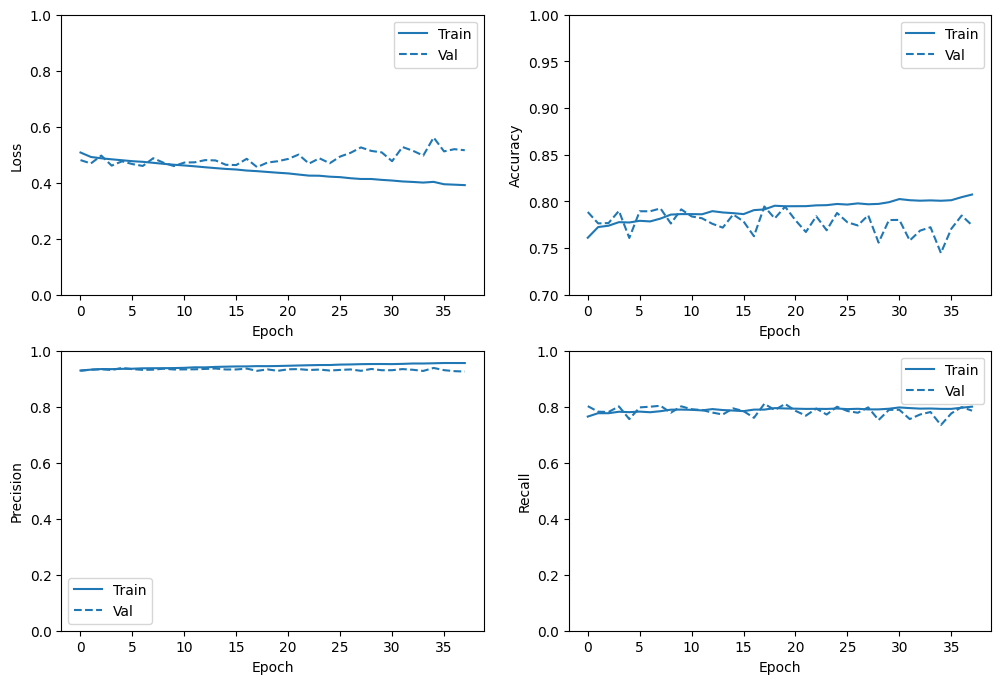

In [ ]:
plot_metrics(history)

In [ ]:
train_pred = rna.predict(X_train)
test_pred = rna.predict(X_test)

print('Número de exemplos positivos do conjunto de teste =', len(y_test[y_test > 0.9]))
results = rna.evaluate(X_test, y_test, verbose=0)

for name, value in zip(rna.metrics_names, results):
    print(f'{name}: {value:.4f}')

1418/1418 [==============================] - 2s 1ms/step
Número de exemplos positivos do conjunto de teste = 36944
loss: 0.4557
accuracy: 0.7946
precision: 0.9282
recall: 0.8104
auc: 0.8443


In [ ]:
precision = results[2]
recall = results[3]
F1 = 2*precision*recall/(precision + recall)
print(f'Pontuação F1 = {F1:.4f}')

Pontuação F1 = 0.8653


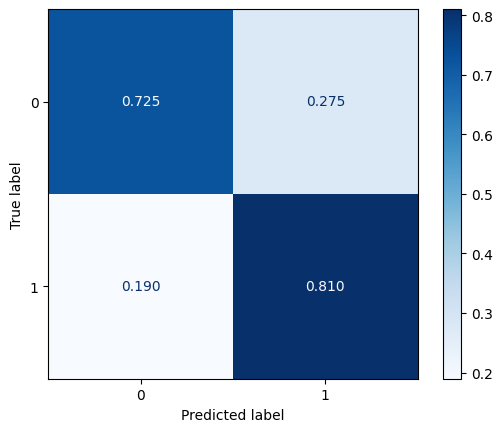

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

789/789 [==============================] - 1s 1ms/step


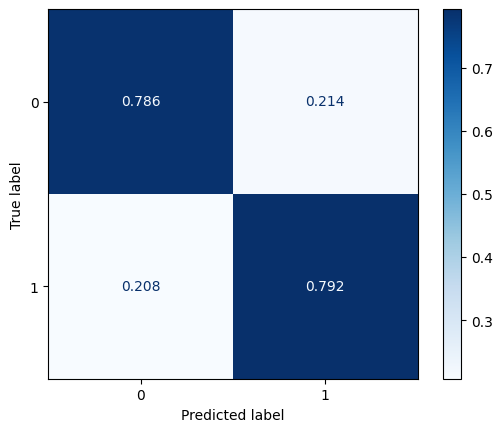

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_mama, np.round(rna.predict(X_test_mama)),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

630/630 [==============================] - 1s 1ms/step


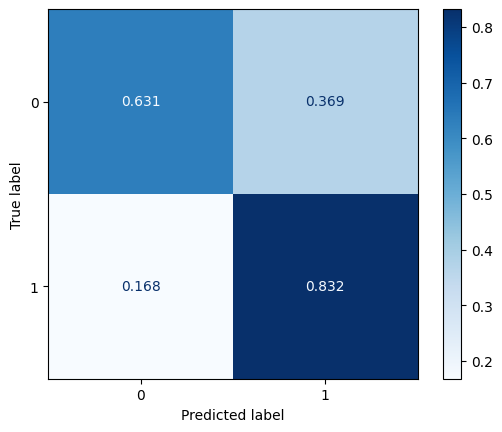

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_prost, np.round(rna.predict(X_test_prost)),
                                        normalize='true', cmap='Blues',
                                        values_format='.3f')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, np.round(test_pred))

0.7678146184429708

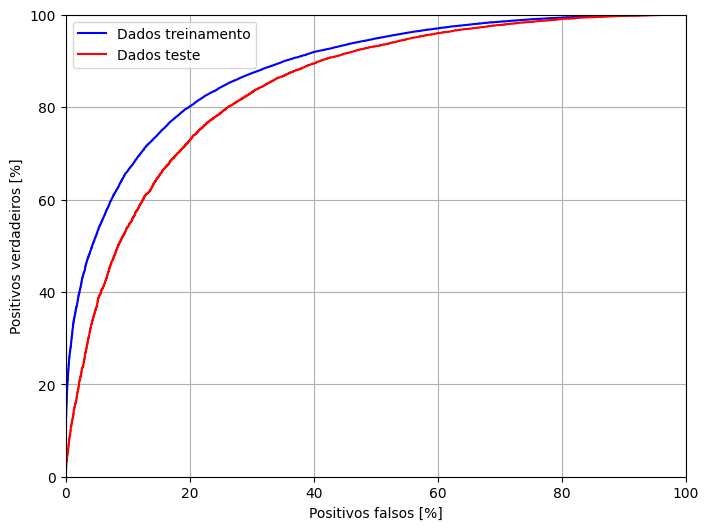

In [ ]:
fp_train, tp_train, _ = roc_curve(y_train, train_pred)
fp_test, tp_test, _ = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(100*fp_train, 100*tp_train, 'b', label='Dados treinamento')
plt.plot(100*fp_test, 100*tp_test, 'r', label='Dados teste')
plt.xlabel('Positivos falsos [%]')
plt.ylabel('Positivos verdadeiros [%]')
plt.xlim([0,100])
plt.ylim([0,100])
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
custo_e_metricas_train = rna.evaluate(X_train, y_train)
custo_e_metricas_test = rna.evaluate(X_test, y_test)

1418/1418 [==============================] - 2s 2ms/step - loss: 0.4557 - accuracy: 0.7946 - precision: 0.9282 - recall: 0.8104 - auc: 0.8443
